# Initial Project Analysis Pipeline
## July 2023


Brief thoughts on pipeline here:
- Gather all data
- Identify first base receives that are outs and that are not outs, and those that are just bad throws, but not received (like that play 203)

    - Other considerations here:
        - I might need to filter out throws that start too close to first for my method?
        - vertical angle?
        - velos?

- Build a probability model for this
- Make some calibration plots


From there, the path might diverge a little bit
- run expectancy?
- Fields Above Average?



### TODO:
- throw in batter x,y, velo? 
- my model grabber needs to pick the throw before whatever event!

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle
import os
from scipy import stats

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prep Data

### Find throws to first that are just so bad the first baseman didn't catch it

- 203 in 1903_01_TeamNE_TeamA2 is the cannonical example

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


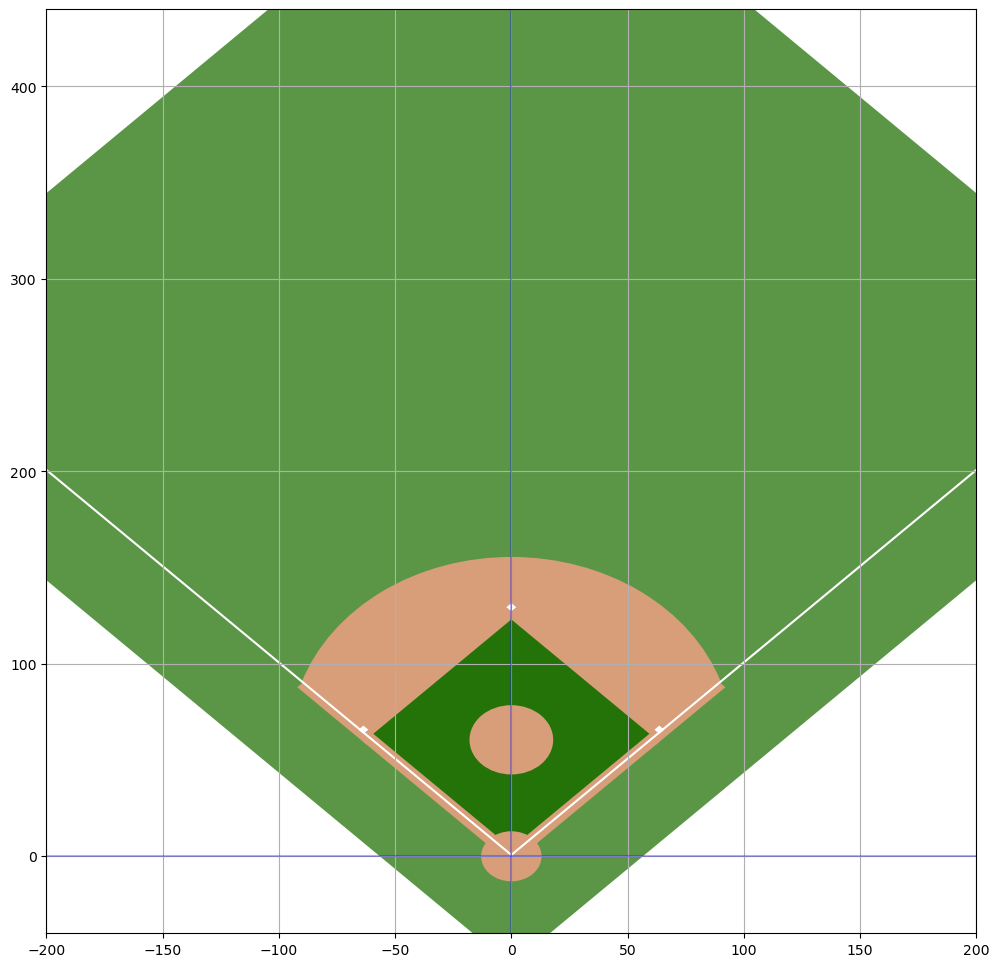

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [4]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()


game_events_1903_01.head(5)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,next_player_position,prev_event_code,prev_event,prev_event_ts,prev_player_position,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
0,1903_01_TeamNE_TeamA2,1,1,1,19199,1,1,pitch,2.0,ball acquired,19661.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.387367,54.28680,6.37134,2.5305,-1.1700,2171
1,1903_01_TeamNE_TeamA2,1,1,1,19661,2,2,ball acquired,5.0,end of play,19661.0,0.0,1.0,pitch,19199.0,1.0,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,2790
2,1903_01_TeamNE_TeamA2,1,1,1,19661,0,5,end of play,NaN,NaN,NaN,NaN,2.0,ball acquired,19661.0,2.0,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,NaN
3,1903_01_TeamNE_TeamA2,2,1,2,29858,1,1,pitch,2.0,ball acquired,30320.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,89.114508,NaN,NaN,-2.288160,52.87770,6.40401,2.3136,-1.0173,2171
4,1903_01_TeamNE_TeamA2,2,1,2,30320,2,2,ball acquired,5.0,end of play,30320.0,0.0,1.0,pitch,29858.0,1.0,NaN,NaN,NaN,0,89.114508,NaN,NaN,-0.469218,-5.52300,0.34590,2.3136,-1.0173,2790


### Get all throws 

In [ ]:
throws = game_events_1903_01.loc[game_events_1903_01["event"] == "throw (ball-in-play)", :]
throws.head(10)

#### Find all bounced throws 

In [ ]:
throws = throws.loc[throws["throw_bounced"] == 1, :]
throws

#### Find all of the throws to first that are outs

In [ ]:
trusted_first_base_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] >= 1)
                                                                     &\
                                                         (game_info_1903_01["trust_this_half"] == 1), "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_outs_plays

In [ ]:
game_events_1903_01.loc[(game_events_1903_01["event"] == "throw (ball-in-play)") &\
                        (game_events_1903_01["play_per_game"].isin(trusted_first_base_outs_plays.values)), :]

In [ ]:
bf_1903_01.clear_plot()

play_id = bf_1903_01.game_obj.get_pid_from_ppg(224)

#bf_1903_01.plot_all_components(play_id=play_id)
#bf_1903_01.fig
# bf_1903_01.create_gif(play_id=play_id, tag="--1-3 out")

In [ ]:
trusted_first_base_not_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] == 0) 
                                                                     #& (game_info_1903_01["trust_this_half"] == 1)
                                                                     ,
                                                                     "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_not_outs_plays

In [ ]:
throws.loc[throws["xy_throw_angle"] < 7]

In [ ]:
## HMM can I use the game info here?
# I think I can use just the trusted plays?
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[throws["xy_throw_angle"] < 7, "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] == 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]


In [ ]:
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[(throws["xy_throw_angle"] < 7) &
                                                        (throws["player_position"].isin([1, 2, 4, 5, 6]))
                                                        , "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] > 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]

In [ ]:
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
player_pos_1903_01.head(3)

In [ ]:
ball_pos_1903_01 = bf_1903_01.game_obj.new_ball_pos.copy()
ball_pos_1903_01.head(3)

In [ ]:
def compute_throw_angle(a, target_point = np.array([63.63961031, 63.63961031])):
    """
    target_point defaults to first base
    
    """
    
    # TODO: do I NEED THE angle of inclination even here?
    # I think not for now!
        
    # make a vector from the first point to the target point
    xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

    # scale it to be a unit vector
    unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))
    
    # Maybe the whole window so we don't get noise?
    throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
        - a[["ball_position_x", "ball_position_y"]].iloc[0].values
    
    # the other one is a unit vect, so we don't need to divide here
    xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))
    
    xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

    # hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 

    return xy_angle_to_first_deg
    
    

In [ ]:
def fill_throw_angle(timestamp, ball_pos_df, target_point = np.array([63.63961031, 63.63961031])): 
    """
    
    """
    
    ball_pos_df = ball_pos_df.copy()
    
    buffer_ms = -10
    snapshot_time = 250

    # find when the ball is in the air with a buffer or not
    ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                       (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                       # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                       :
                                      ] 
    
    # print(ball_in_air_df["play_id"].describe())
    angle = compute_throw_angle(ball_in_air_df, target_point)
    
    return angle
    
    
    

In [ ]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet

game_events_1903_01.loc[(game_events_1903_01["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1903_01["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

In [ ]:
throws["xy_throw_angle"] = np.nan
throws["xy_throw_angle"] = throws.apply(lambda row: fill_throw_angle(row["timestamp"], ball_pos_1903_01), axis = 1)

In [ ]:
throws["xy_throw_angle"].loc[(throws["player_position"].isin([1, 2, 4, 5, 6]))].plot(kind="hist")

In [ ]:
# because this is like the cosine similarity to each other, we don't have a sense for which side of the bag the throw went to
# want infielder throws only
# note that higher angles throws are either throws behind a runner (usually in the [5, 10] range)
# or they are bad throws?

throws.loc[(throws["xy_throw_angle"] > 100) & (throws["player_position"].isin([1, 2, 4, 5, 6]) ), :]

In [ ]:
# look at all of these with the outs

In [ ]:
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_01.loc[game_info_1903_01["play_per_game"] == 124]

game_info_1903_01.loc[(game_info_1903_01["inning"] == 4) & (game_info_1903_01["top_bottom_inning"] == "Top")]

In [ ]:
bf_1903_01.clear_plot()

play_id = 25 # throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--4-6-3 dp")

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].describe()

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].plot(kind="hist", alpha=0.5)

### the method I have below pulls the end play, but I want the last throw before that!

In [ ]:
bf = Baseball_Field("1902_25_TeamMH_TeamA3")
g = bf.game_obj
g_game_info = g.game_info_df.copy()
g_game_events = g.game_events_df.copy()

In [ ]:
trusted_successful_first_base_outs_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]

In [ ]:
trusted_successful_first_base_outs_plays

In [ ]:
g_game_events.loc[
    (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_plays.values)) &
    (g_game_events["event"] == "throw (ball-in-play)")
].groupby("play_per_game").last()

In [ ]:
bf.clear_plot()

play_id = 169 #bf.game_obj.get_pid_from_ppg(224)

#bf.plot_all_components(play_id=play_id)
#bf.fig
# bf.create_gif(play_id=play_id, tag="--5-3 out")

## Collect the plays into a csv, will use this to compute features later

In [5]:
all_games = get_all_game_strs()

Gathered a list of 97 games


### Use full sequences as outs ground truth

In [127]:

total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0



model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "player_id", #"play_per_game",
                "player_position",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_bounced",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "batter_x","batter_y",
                "ball_position_x", "ball_position_y", "ball_position_z",
                "type"]


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
    # NOTE: WILL DEAL WITH FILTERING 
    
    # find the plays that are outs, that we trust, and end with the first baseman
    trusted_successful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    # get the last throw! (I am assuming this is a throw to first because it end with first!)
    trusted_successful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_successful_first_base_outs_throws["type"] = "trusted_first_base_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_throws[cols_to_save]])
    trusted_successful_first_base_outs_throws = trusted_successful_first_base_outs_throws.shape[0]
    
    
    trusted_successful_first_base_outs_receives["type"] = "trusted_first_base_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (~g_game_events["prev_player_position"].isin([7, 8, 9])) &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs_receives["type"] = "trusted_first_base_not_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_unsuccessful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_unsuccessful_first_base_outs_throws["type"] = "trusted_first_base_not_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_throws[cols_to_save]])
    trusted_unsuccessful_first_base_outs_throws = trusted_unsuccessful_first_base_outs_throws.shape[0]

    
    trusted_double_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 2) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]
    
    # I think I want all throws! there should be some overlap here! 
    trusted_double_plays_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_double_plays.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ]#.groupby("play_per_game").last()
    
    trusted_double_plays_throws["type"] = "trusted_double_play"
    model_dataset = pd.concat([model_dataset, trusted_double_plays_throws[cols_to_save]])
    trusted_double_plays_throws = trusted_double_plays_throws.shape[0]

    
    # TODO: Add overthrows here!
    throws_out_of_play = g_game_events.loc[
        (g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["xy_throw_angle"] <= 10)
        , "play_per_game"
    ]
    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["play_per_game"].isin(throws_out_of_play.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
        trusted_outs,
        trusted_successful_first_base_outs_throws,
        trusted_unsuccessful_first_base_outs_throws,
        trusted_double_plays_throws,
        throws_out_of_play
    ))
    
    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs_throws
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs_throws
    total_trusted_double_plays += trusted_double_plays_throws
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_trusted_double_plays,
    total_throws_out_of_play
    
))


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679
31 trusted outs in this game 
7 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_16_TeamNI_TeamA3
41 trusted outs in this game 
8 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_02_TeamMG_TeamA3
33 trusted outs in this game 
10 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_08_TeamNJ_TeamB
39 trusted outs in this game 
13 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_08_TeamKL_TeamB
12 trusted outs in this game 
4 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_23_TeamNA_TeamA1
32 tru

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
4 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_17_TeamNI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


28 trusted outs in this game 
8 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_27_TeamNK_TeamB
36 trusted outs in this game 
4 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_12_TeamLJ_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_09_TeamKK_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_01_TeamLG_TeamA3
9 trusted outs in this game 
1 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_03_TeamKJ_TeamB
Distance between ball and player is large on average, should maybe clean up 6.403561421830762
6 trusted outs in this game 
0 trusted first ba

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_32_TeamNB_TeamA1
33 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1901_07_TeamLK_TeamB
9 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_23_TeamMA_TeamA1
31 trusted outs in this game 
5 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1902_15_TeamMK_TeamB
39 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1902_04_TeamML_TeamB
31 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

W

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


41 trusted outs in this game 
11 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_19_TeamNL_TeamB
37 trusted outs in this game 
9 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_02_TeamLG_TeamA3
5 trusted outs in this game 
2 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_31_TeamNB_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_09_TeamLK_TeamB
9 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_10_TeamMI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_02_TeamNE_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


29 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_26_TeamMC_TeamA1
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_26_TeamNK_TeamB
32 trusted outs in this game 
7 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_24_TeamMA_TeamA1
36 trusted outs in this game 
11 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_01_TeamMG_TeamA3
24 trusted outs in this game 
5 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_18_TeamLH_TeamA3
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_30_TeamNB_TeamA1
36 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_11_TeamMI_TeamA3
39 trusted outs in this game 
8 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_05_TeamND_TeamA2
Distance between ball and player is large on average, should maybe clean up 14.67974023000007
35 trusted outs in this game 
5 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_26_TeamNH_TeamA3
34 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_15_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1900_04_TeamKK_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_20_TeamNL_TeamB
37 trusted outs in this game 
12 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1902_06_TeamML_TeamB
23 trusted outs in this game 
5 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_18_TeamNI_TeamA3
46 trusted outs in this game 
14 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1902_09_TeamMJ_TeamB
47 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encount

36 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_29_TeamMF_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


16 trusted outs in this game 
5 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_28_TeamMC_TeamA1
15 trusted outs in this game 
4 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_04_TeamLI_TeamA3
19 trusted outs in this game 
3 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_28_TeamNF_TeamA2
48 trusted outs in this game 
5 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_16_TeamLH_TeamA3
12 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_25_TeamMH_TeamA3
41 trusted outs in this game 
5 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


21 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_17_TeamMB_TeamA1
15 trusted outs in this game 
2 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_08_TeamMJ_TeamB
40 trusted outs in this game 
10 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_10_TeamNJ_TeamB
38 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1903_29_TeamNF_TeamA2
41 trusted outs in this game 
10 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1901_15_TeamLL_TeamB
Distance between ball and player is large on average, should maybe clean up 5.3524560073690175
15 trusted outs in this game 
2 trusted f

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1419: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


35 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_11_TeamLJ_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_31_TeamMF_TeamA2
42 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

---------------
2219 trusted outs in this game 
485 trusted first base outs	92 trusted_first_base_not_outs --- 	 trusted double plays 88 	 throws to end play 0



In [129]:
model_dataset.to_csv("model_dataset.csv")

### Use outs at first as outs ground truth

In [ ]:

total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0

model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "player_id", #"play_per_game",
                "player_position",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_bounced",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "batter_x","batter_y",
                "ball_position_x", "ball_position_y", "ball_position_z",
                "type"]


for which_game in all_games:
    """
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    """
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game, which_outs=["at_first"])
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    """
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
    # NOTE: WILL DEAL WITH FILTERING 
    
    """
    
    # find the plays that are outs, that we trust, and end with the first baseman
    trusted_successful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["is_out_at_first"] == 1), "play_per_game"].values))
        , :
    ]
    
    # get the last throw! (I am assuming this is a throw to first because it end with first!)
    trusted_successful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_successful_first_base_outs_throws["type"] = "trusted_first_base_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_throws[cols_to_save]])
    trusted_successful_first_base_outs_throws = trusted_successful_first_base_outs_throws.shape[0]
    
    
    trusted_successful_first_base_outs_receives["type"] = "trusted_first_base_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["is_out_at_first"] == -1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs_receives["type"] = "trusted_first_base_not_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_unsuccessful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_unsuccessful_first_base_outs_throws["type"] = "trusted_first_base_not_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_throws[cols_to_save]])
    trusted_unsuccessful_first_base_outs_throws = trusted_unsuccessful_first_base_outs_throws.shape[0]

    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["xy_throw_angle"] <= 10)
        , "play_per_game"
    ]
    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["play_per_game"].isin(throws_out_of_play.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted first base outs\t{} trusted_first_base_not_outs --- \t throws to end play {}\n".format(
        #trusted_outs,
        trusted_successful_first_base_outs_throws,
        trusted_unsuccessful_first_base_outs_throws,
        throws_out_of_play
    ))
    
    
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs_throws
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs_throws
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted first base outs\t{} trusted_first_base_not_outs --- \t throws to end play {}\n".format(
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_throws_out_of_play
    
))


In [ ]:
# Write the model_dataset 
model_dataset.to_csv("new_model_dataset.csv")

In [130]:
def load_model_data(file_path="new_model_dataset.csv"):
    
    model_dataset = pd.read_csv(file_path, index_col=0)


    trusted_first_base_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_throws"]
    trusted_first_base_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]


    combined_outs = trusted_first_base_out_throws.merge(
        trusted_first_base_out_receives,
        on=["game_str", "play_id"],
        how="left",
        suffixes=["_throw", "_receive"]
    )

    combined_outs["target"] = 1


    trusted_first_base_not_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_throws"]
    trusted_first_base_not_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]


    combined_not_outs = trusted_first_base_not_out_throws.merge(
        trusted_first_base_not_out_receives,
        on=["game_str", "play_id"],
        how="left",
        suffixes=["_throw", "_receive"]
    )


    combined_not_outs["target"] = 0


    train = pd.concat([combined_outs, combined_not_outs])

    train = train.loc[:, ~train.columns.isin(['play_per_game'])]
    
    return train


## A description of this phenomenon!

In [455]:
train = load_model_data("model_dataset.csv")

In [456]:
# refactor this -- should be in player details!

train["dist_from_bag_receive"] = train.apply(
    lambda row:
        row[["ball_position_x_receive", "ball_position_y_receive", "ball_position_z_receive"]].values \
        - np.array([63.63961031, 63.63961031, 0])
    , axis = 1).apply(lambda vect: np.sqrt(vect.dot(vect)))

In [457]:
# refactor this -- should be in player details!

train["dist_from_bag_throw"] = train.apply(
    lambda row:
        row[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values \
        - np.array([63.63961031, 63.63961031, 0])
    , axis = 1).apply(lambda vect: np.sqrt(vect.dot(vect)))

In [458]:
train = train.loc[train["dist_from_bag_receive"] < 15]

In [459]:
def compute_shorten_throw_by(i):
    vect_throw_to_bag = train[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values[i,: ] \
        - np.array([63.63961031, 63.63961031, 0])

    vect_receive_to_bag = train[["ball_position_x_receive", "ball_position_y_receive", "ball_position_z_receive"]].values[i,: ] \
        - np.array([63.63961031, 63.63961031, 0])

    shorten_throw_by_vect = vect_receive_to_bag.dot(vect_throw_to_bag) / vect_throw_to_bag.dot(vect_throw_to_bag) * vect_throw_to_bag 

    shortern_throw_by_dist = np.sqrt(shorten_throw_by_vect.dot(shorten_throw_by_vect))
    
    perpendicular_vect = vect_receive_to_bag - shorten_throw_by_vect
    
    perpendicular_dist = np.sqrt(perpendicular_vect.dot(perpendicular_vect))
    
    return shortern_throw_by_dist #, perpendicular_dist
    
    

In [460]:
train["shorten_throw_by"] = list(map(compute_shorten_throw_by, range(train.shape[0])))

In [461]:
# 27 is average sprint speed in fps

# 1.4667 is mph to fps conversion

train["batter_time_to_first_throw"] = (train["batter_dist_to_first_throw"] / 27)
train["throw_time_to_first_throw"] = (train["dist_from_bag_throw"] / (train["throw_velo_throw"] * 1.4667))

In [462]:
outs = train.loc[
    train["target"] == 1,
    :
]


not_outs = train.loc[
    train["target"] == 0,
    :
]

In [463]:
outs.shape

(484, 40)

In [407]:
not_outs.shape

(78, 40)

In [408]:
train

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,dist_from_bag_throw,shorten_throw_by,batter_time_to_first_throw,throw_time_to_first_throw
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,0.0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.53530,121.16550,5.694690,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1,5.116850,114.792510,4.399956,1.924225,1.076765
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,0.0,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.59556,137.95980,5.613210,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1,5.995480,115.500840,4.652653,2.002858,1.052458
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,0.0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.21340,6.006360,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1,7.230630,85.946530,5.767047,1.063900,0.937100
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,185.0,6993.0,4.0,2.377584,4.687237,0.0,63.133569,39.970366,30.3021,121.4715,35.5083,35.2449,29.72007,117.49770,5.624520,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,21.603012,NaN,NaN,48.4122,48.3159,59.3652,62.8815,6.934410,1,8.181159,63.897295,2.240445,1.480384,0.690050
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,223.0,4044.0,1.0,6.460406,-2.494484,0.0,63.042179,34.974859,25.4832,32.9205,38.4414,39.3849,30.47940,33.86130,5.690250,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,20.634997,NaN,NaN,48.4140,49.7118,60.6081,67.4022,1.922883,1,5.200444,44.930238,0.012828,1.295365,0.485922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1903_29_TeamNF_TeamA2,NaN,trusted_first_base_not_out_throws,235.0,8230.0,5.0,3.133706,6.068064,0.0,69.847228,25.213226,-13.3875,83.3025,45.7026,45.9204,-13.94433,79.62300,3.564360,NaN,trusted_first_base_not_out_receives,4728.0,3.0,NaN,NaN,0.0,NaN,1.852603,NaN,NaN,62.3514,62.3082,61.9590,67.0704,5.236680,0,6.482097,79.293387,2.571330,0.933823,0.774010
88,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,24.0,9991.0,2.0,3.905028,2.495060,0.0,71.768956,NaN,NaN,NaN,NaN,NaN,5.06799,19.12845,4.529010,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,71.1648,72.6894,2.551845,0,12.043217,73.704749,11.288579,NaN,0.700193
89,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,38.0,7468.0,4.0,1.037926,5.407066,0.0,66.640980,35.784509,38.8428,137.2914,37.5894,39.1056,36.45660,135.84750,3.861210,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,13.036025,NaN,NaN,53.3625,55.6197,63.7560,63.3762,3.834150,0,3.844950,77.251565,0.095528,1.325352,0.790359
90,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,237.0,4131.0,1.0,5.854195,17.025390,0.0,29.724053,44.351118,25.2450,53.1012,30.5565,34.1010,26.88408,55.15740,2.358609,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,19.564819,NaN,NaN,48.5805,51.149

In [409]:
train["player_id_receive"].value_counts().values

array([43, 40, 39, 28, 22, 20, 19, 18, 17, 16, 15, 15, 14, 14, 12, 11, 11,
       10, 10,  9,  8,  8,  8,  7,  7,  6,  6,  6,  6,  6,  5,  5,  5,  5,
        5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,
        3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1])

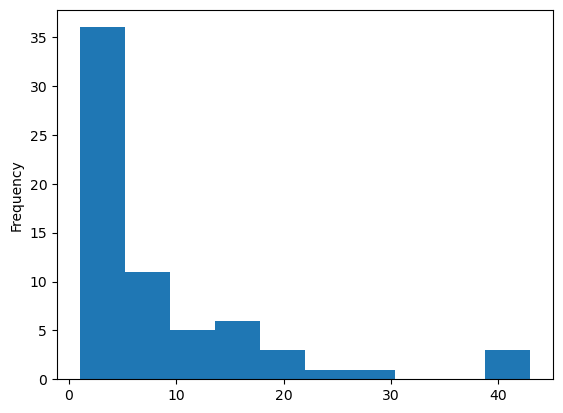

In [410]:
plt.close()

f, a  = plt.subplots()


train["player_id_receive"].value_counts().plot(kind="hist", ax=a)


plt.show()

In [140]:
bf = Baseball_Field("1903_06_TeamND_TeamA2")

Distance between ball and player is large on average, should maybe clean up 15.614163808346984


In [141]:
g_game_events = bf.game_obj.game_events_df.copy()

In [142]:
throws = g_game_events.loc[g_game_events["event"] == "throw (ball-in-play)", :]

throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,next_player_position,prev_event_code,prev_event,prev_event_ts,prev_player_position,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
40,1903_06_TeamND_TeamA2,12,3,12,228274,8,3,throw (ball-in-play),2.0,ball acquired,229624.0,5.0,2.0,ball acquired,227324.0,8.0,10.385907,6.244960,72.976509,0,31.150939,-65.4420,238.6455,-63.566100,239.109000,5.832390,50.5044,91.8858,1177
51,1903_06_TeamND_TeamA2,15,4,15,300774,2,3,throw (ball-in-play),2.0,ball acquired,302024.0,4.0,2.0,ball acquired,300074.0,2.0,48.408620,3.093778,75.778152,0,92.848374,-0.2481,-3.7899,1.263366,-1.634841,6.481920,-3.6147,-0.3735,1195
63,1903_06_TeamND_TeamA2,17,5,17,463274,6,3,throw (ball-in-play),2.0,ball acquired,464124.0,3.0,2.0,ball acquired,462524.0,6.0,1.224602,2.997335,69.148599,0,38.644448,-15.1536,105.5373,-14.643060,100.191300,5.535810,35.2689,37.4004,6674
77,1903_06_TeamND_TeamA2,19,6,19,530924,7,3,throw (ball-in-play),16.0,ball bounce,532674.0,255.0,2.0,ball acquired,528874.0,7.0,15.175195,10.079144,62.604666,1,29.162911,-203.0013,201.9747,-192.039600,195.358500,5.984460,50.4996,89.6745,5177
90,1903_06_TeamND_TeamA2,22,7,22,625324,7,3,throw (ball-in-play),2.0,ball acquired,626974.0,6.0,2.0,ball acquired,623224.0,7.0,4.750103,11.359865,55.669912,0,2.369563,-153.0381,202.6890,-152.502600,201.579000,6.656370,61.2846,63.3774,5177
111,1903_06_TeamND_TeamA2,26,8,26,735124,8,3,throw (ball-in-play),2.0,ball acquired,736774.0,6.0,2.0,ball acquired,733824.0,8.0,19.618751,10.398160,62.569671,0,13.322105,27.8679,261.8421,26.015970,260.087700,6.108210,58.0512,51.5463,8032
126,1903_06_TeamND_TeamA2,29,9,29,821874,4,3,throw (ball-in-play),2.0,ball acquired,822724.0,3.0,2.0,ball acquired,820324.0,4.0,0.877317,3.873160,70.904748,0,51.080418,55.7145,142.7604,53.289000,145.237500,2.916018,30.5907,24.6912,6851
153,1903_06_TeamND_TeamA2,36,11,36,1060774,6,3,throw (ball-in-play),2.0,ball acquired,1062124.0,3.0,2.0,ball acquired,1059374.0,6.0,1.348181,6.044604,80.113805,0,44.257551,-64.8597,131.9976,-63.221100,128.942700,5.976090,32.6205,32.0715,1972
266,1903_06_TeamND_TeamA2,68,20,70,2056524,1,3,throw (ball-in-play),2.0,ball acquired,2057074.0,3.0,2.0,ball acquired,2056274.0,1.0,6.967940,17.431326,25.505125,0,31.355156,39.0201,57.7122,42.349500,59.394300,1.244166,41.1927,41.7471,9464
277,1903_06_TeamND_TeamA2,71,21,73,2187224,2,3,throw (ball-in-play),2.0,ball acquired,2187974.0,5.0,2.0,ball acquired,2186474.0,2.0,92.971256,0.700019,85.014516,0,88.376547,-0.7137,-5.9037,-4.080810,-0.768990,5.205360,2.7708,-0.4338,9604


In [143]:
throws["player_id"].value_counts()

player_id
9464    5
1177    4
6674    4
6875    4
6851    3
1972    3
1195    2
5177    2
9604    2
1547    2
8032    1
6902    1
2480    1
Name: count, dtype: int64

In [144]:
bf.clear_plot()


#### Throws to first that were outs

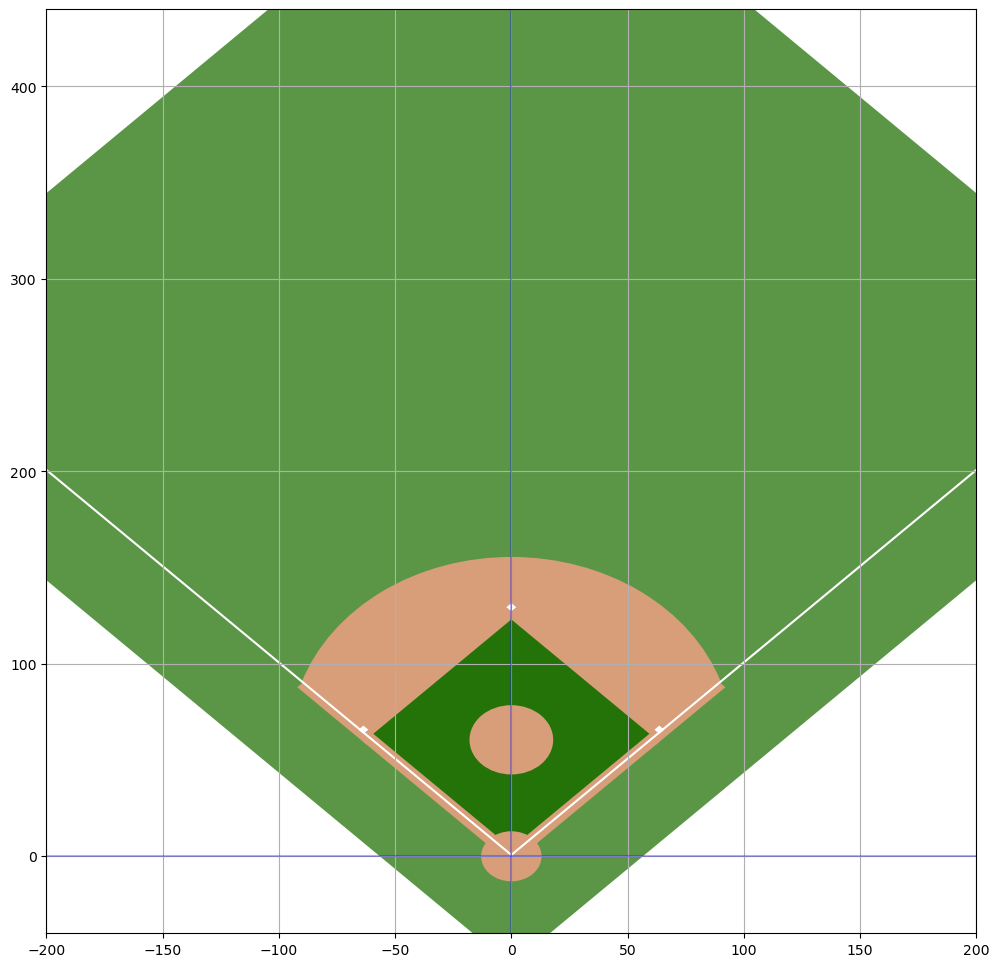

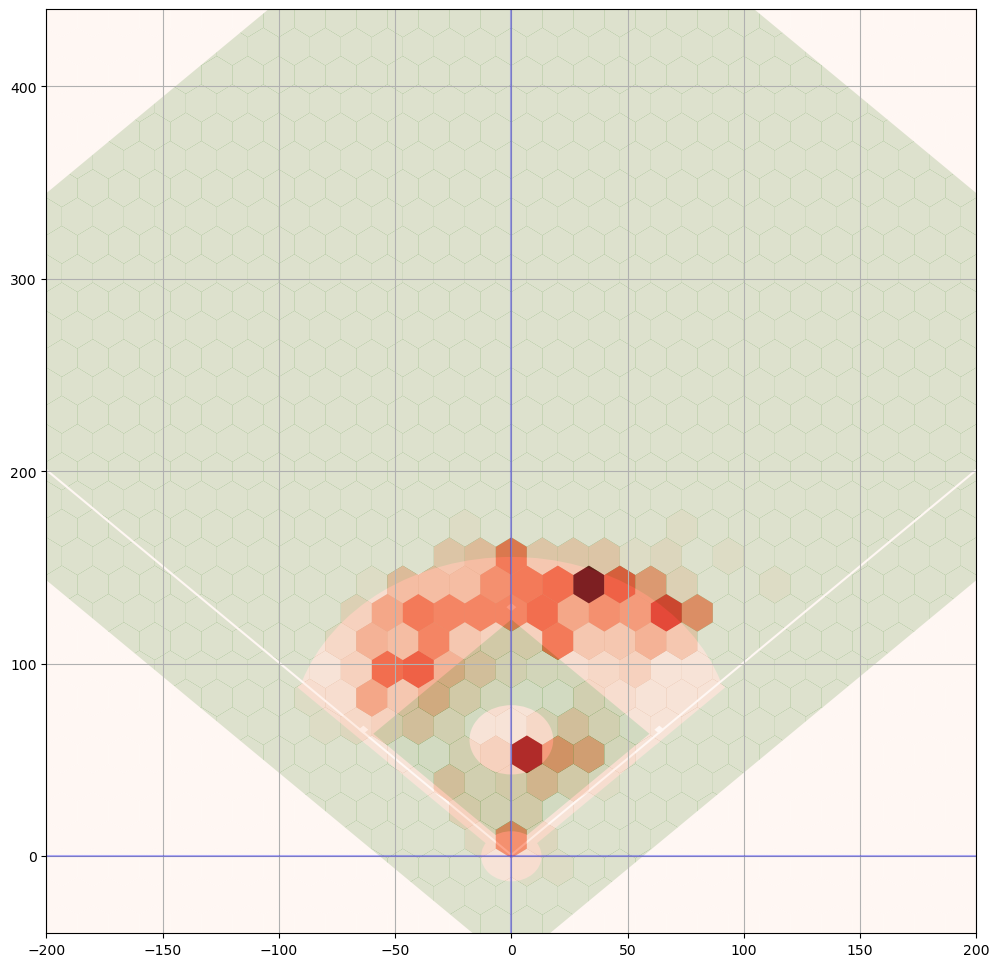

In [145]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(outs["thrower_x_throw"], 
             outs["thrower_y_throw"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()

#### Throws to first that were not outs

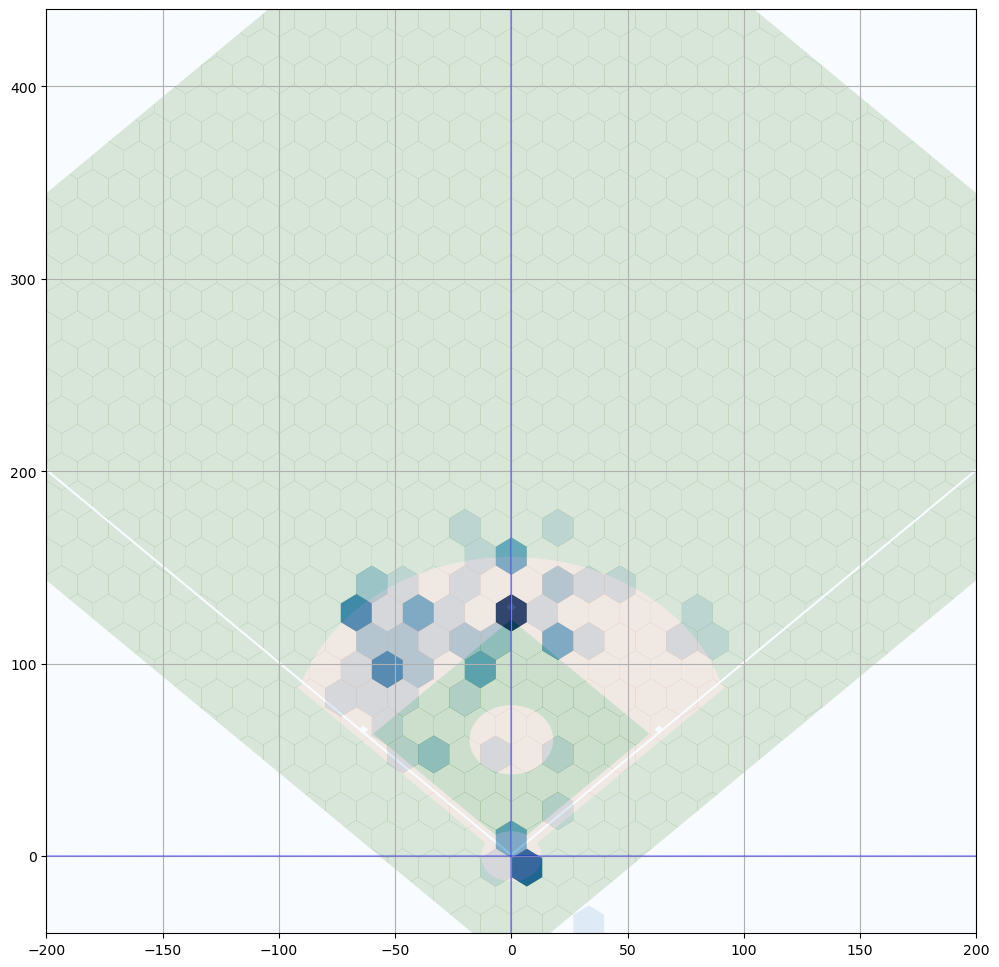

In [146]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(not_outs["thrower_x_throw"], 
             not_outs["thrower_y_throw"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()



### Batter plots


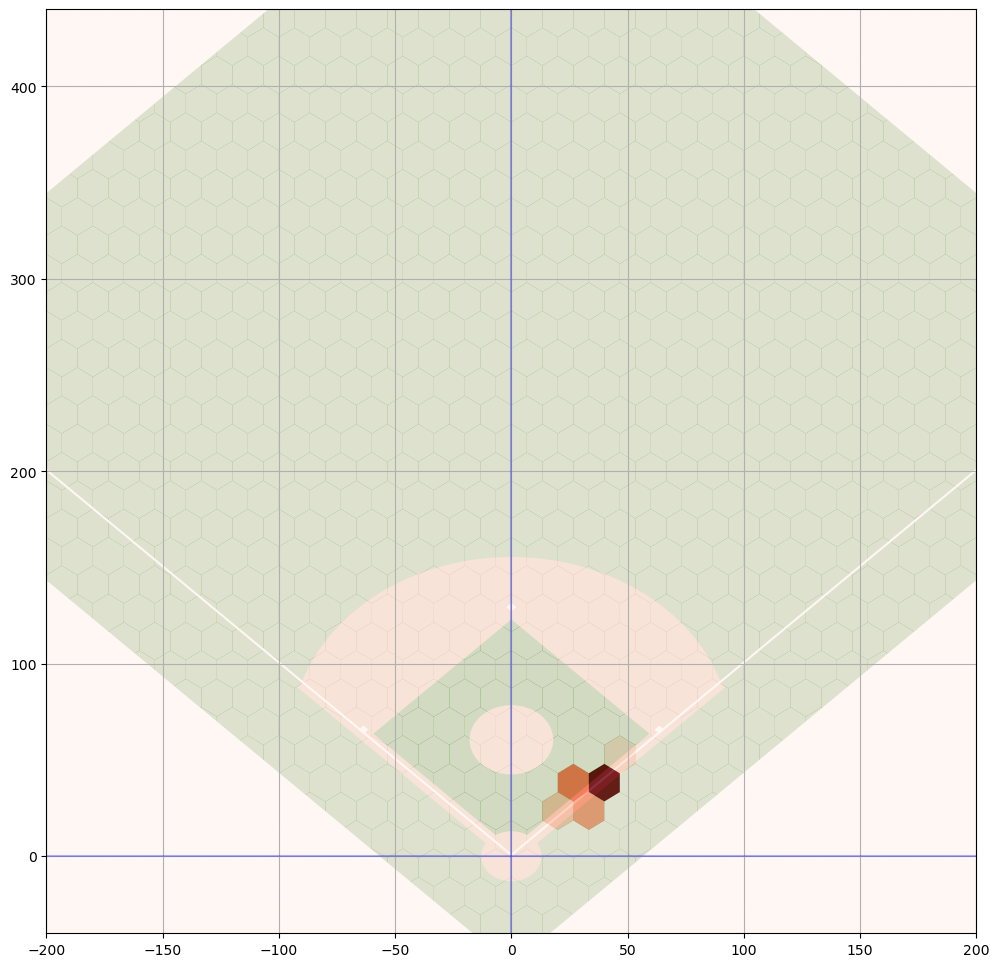

In [147]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(outs["batter_x_throw"], 
             outs["batter_y_throw"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


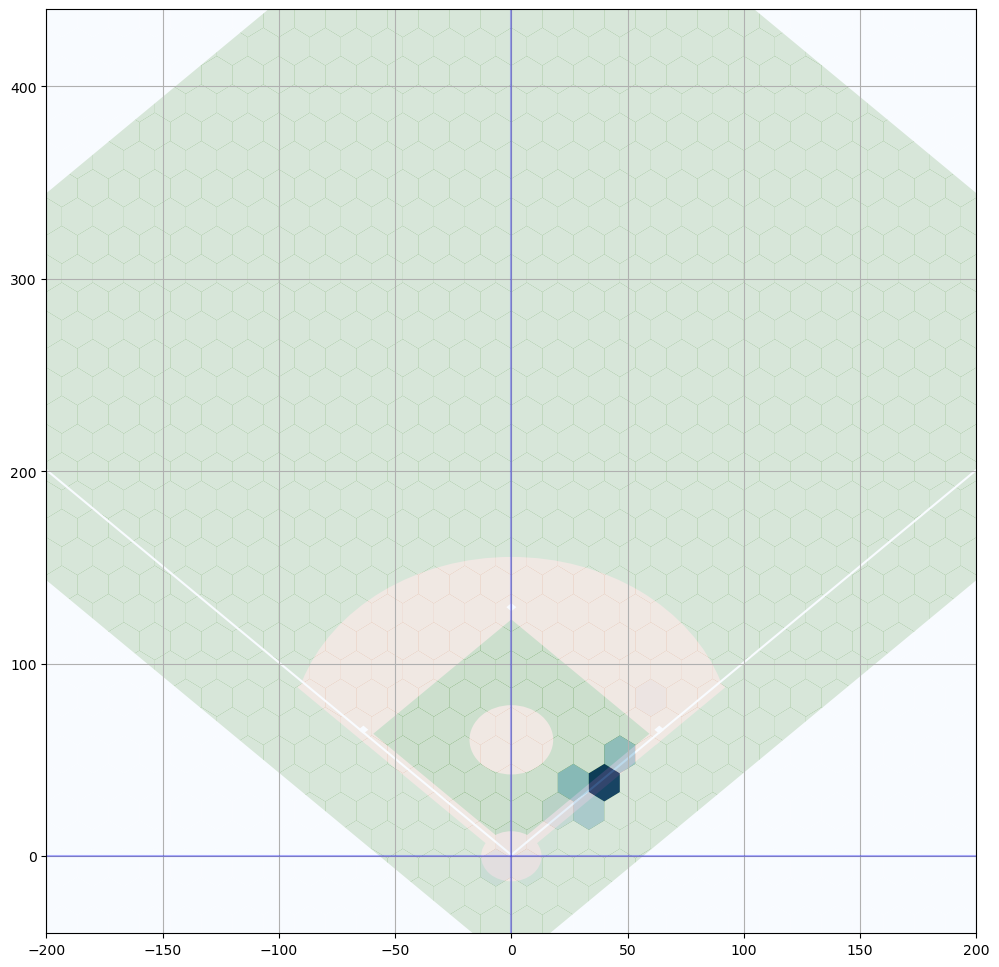

In [148]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(not_outs["batter_x_throw"], 
             not_outs["batter_y_throw"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


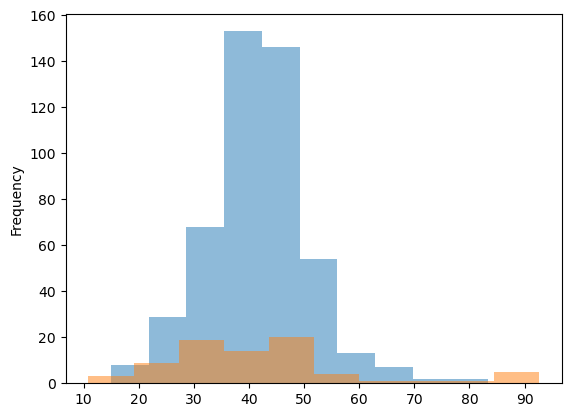

In [149]:
f, a  = plt.subplots()


outs["batter_dist_to_first_throw"].plot(kind="hist", alpha=0.5, ax=a)
not_outs["batter_dist_to_first_throw"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

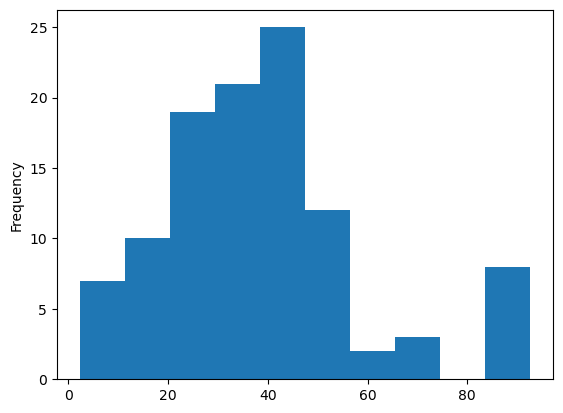

In [77]:
f, a  = plt.subplots()

trusted_first_base_not_out["batter_dist_to_first"].plot(kind="hist", ax=a)

plt.show()


In [78]:
bf.clear_plot()


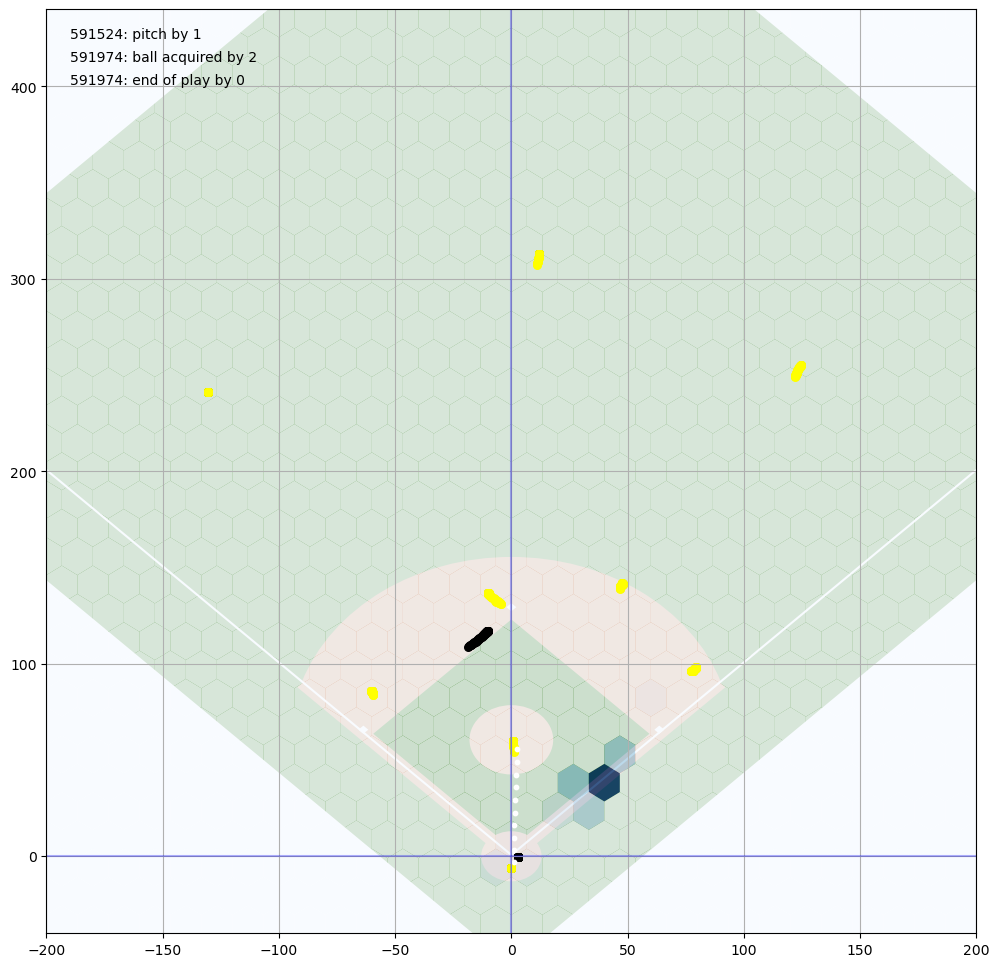

In [79]:
bf.clear_plot()

play_id = 21# throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf.plot_all_components(play_id=play_id)
bf.fig

# bf.create_gif(play_id=play_id, tag="--throw_to_end_play")

## A description of the throws

In [150]:
not_outs

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,shorten_throw_by
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_not_out_throws,136.0,7071.0,2.0,4.043129,2.700385,0.0,72.049428,87.838535,0.4875,-4.4328,3.0078,0.0834,1.300593,-6.23205,6.054330,NaN,trusted_first_base_not_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,87.755115,NaN,NaN,2.5248,0.6639,57.4209,61.7751,3.735570,0,7.490210,5.760811
1,1903_16_TeamNI_TeamA3,NaN,trusted_first_base_not_out_throws,162.0,1258.0,5.0,4.058150,0.972882,0.0,68.085284,28.426292,-30.8841,55.5534,43.7955,43.2861,-28.511940,53.18820,5.461320,NaN,trusted_first_base_not_out_receives,1784.0,3.0,NaN,NaN,0.0,NaN,2.910815,NaN,NaN,60.7692,63.1563,60.8613,67.8513,-1.542582,0,5.276068,2.191350
2,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out_throws,90.0,6201.0,5.0,5.498954,4.967871,0.0,77.104126,32.771272,-32.9721,114.2355,39.0390,41.9886,-33.565800,111.36240,4.000170,NaN,trusted_first_base_not_out_receives,6266.0,3.0,NaN,NaN,0.0,NaN,3.609238,NaN,NaN,60.6081,61.6809,64.0128,70.2018,3.706350,0,7.545769,2.692046
3,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out_throws,218.0,1144.0,6.0,2.548375,4.414598,1.0,74.465009,40.627713,-38.3232,105.1734,34.2768,35.5605,-39.951600,102.21630,4.351530,NaN,trusted_first_base_not_out_receives,2488.0,3.0,NaN,NaN,0.0,NaN,8.351890,NaN,NaN,57.4464,58.0362,56.1579,59.1993,0.000000,0,8.700135,5.457523
4,1900_08_TeamKL_TeamB,NaN,trusted_first_base_not_out_throws,130.0,2653.0,5.0,1.410586,2.916430,0.0,73.041541,37.927362,-37.0755,96.4767,36.5808,37.0632,-33.406500,93.19650,6.422550,NaN,trusted_first_base_not_out_receives,1334.0,3.0,NaN,NaN,0.0,NaN,12.702344,NaN,NaN,54.2604,55.0734,61.1949,67.5621,4.647930,0,6.554829,3.768187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1903_29_TeamNF_TeamA2,NaN,trusted_first_base_not_out_throws,235.0,8230.0,5.0,3.133706,6.068064,0.0,69.847228,25.213226,-13.3875,83.3025,45.7026,45.9204,-13.944330,79.62300,3.564360,NaN,trusted_first_base_not_out_receives,4728.0,3.0,NaN,NaN,0.0,NaN,1.852603,NaN,NaN,62.3514,62.3082,61.9590,67.0704,5.236680,0,6.482097,2.571330
88,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,24.0,9991.0,2.0,3.905028,2.495060,0.0,71.768956,NaN,NaN,NaN,NaN,NaN,5.067990,19.12845,4.529010,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,71.1648,72.6894,2.551845,0,12.043217,11.288579
89,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,38.0,7468.0,4.0,1.037926,5.407066,0.0,66.640980,35.784509,38.8428,137.2914,37.5894,39.1056,36.456600,135.84750,3.861210,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,13.036025,NaN,NaN,53.3625,55.6197,63.7560,63.3762,3.834150,0,3.844950,0.095528
90,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,237.0,4131.0,1.0,5.854195,17.025390,0.0,29.724053,44.351118,25.2450,53.1012,30.5565,34.1010,26.884080,55.15740,2.358609,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,19.564819,NaN,NaN,48.5805,51.1494,61.2372,66.3597,4.883250,0,6.084126,2.030604


### Bounced

In [154]:
outs["throw_bounced_throw"].mean()

0.01859504132231405

In [155]:
not_outs["throw_bounced_throw"].mean()

0.08974358974358974

In [171]:
stats.ttest_ind(outs["throw_bounced_throw"], not_outs["throw_bounced_throw"], axis=0, equal_var=False, alternative="less")

TtestResult(statistic=-2.146489855931526, pvalue=0.017384232651925895, df=82.56553826880395)

In [260]:
all_data = pd.concat([outs, not_outs])

In [261]:
all_data["throw_bounced_throw"].mean()

0.028469750889679714

In [263]:
all_data.loc[
    all_data["throw_bounced_throw"] == 1,
    "target"].mean()

0.5625

In [268]:
all_data.loc[
    all_data["throw_bounced_throw"] == 1,
    ["player_id_receive", "target"]].groupby("player_id_receive").agg(["sum", "count"])

target      
                     sum count
player_id_receive             
1009.0                 0     2
1119.0                 0     1
1286.0                 1     1
1918.0                 1     2
1928.0                 1     1
2480.0                 1     1
2488.0                 0     1
2526.0                 3     4
6442.0                 0     1
6693.0                 1     1
6789.0                 1     1

In [273]:
(9 + 0) / (16 + 2)

0.5

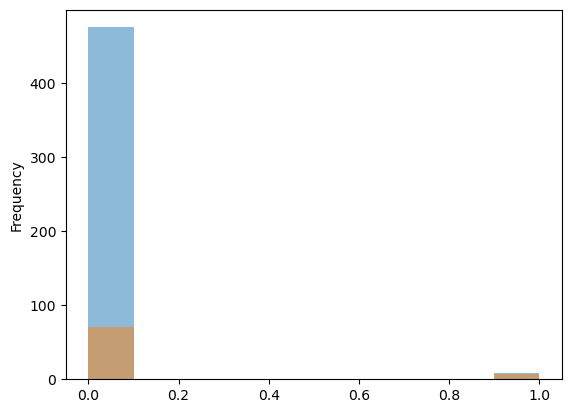

In [151]:
f, a  = plt.subplots()


outs["throw_bounced_throw"].plot(kind="hist", alpha=0.5, ax=a)
not_outs["throw_bounced_throw"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

### Velo

In [177]:
outs["throw_velo_throw"].mean()

64.44725512265282

In [178]:
not_outs["throw_velo_throw"].mean()

69.09162674996692

In [179]:
stats.ttest_ind(outs["throw_velo_throw"], not_outs["throw_velo_throw"], axis=0, equal_var=False, alternative="less")

TtestResult(statistic=-3.506171280514122, pvalue=0.00032039039325960613, df=119.6739831839566)

### Throw angle

In [180]:
outs["xy_throw_angle_throw"].mean()

1.8279816351320064

In [181]:
not_outs["xy_throw_angle_throw"].mean()

2.450398406688396

In [183]:
stats.ttest_ind(outs["xy_throw_angle_throw"], not_outs["xy_throw_angle_throw"], axis=0, equal_var=False, alternative="less")

TtestResult(statistic=-2.726226664722114, pvalue=0.0038334625360105733, df=92.24290366876858)

In [193]:
all_data = pd.concat([outs, not_outs])

In [198]:
xy_summary_stats = all_data[["player_id_receive", "xy_throw_angle_throw", "target"]].groupby(["player_id_receive"]).agg(["mean", "std", "count" ])

In [199]:
xy_summary_stats

xy_throw_angle_throw                    target            \
                                  mean       std count      mean       std   
player_id_receive                                                            
1009.0                        1.909198  1.230446    28  0.857143  0.356348   
1119.0                        1.770797  1.575441     4  0.750000  0.500000   
1167.0                        2.249882  1.624695     6  1.000000  0.000000   
1286.0                        2.164488  1.184635    20  0.900000  0.307794   
1334.0                        0.705614  0.538888     4  0.750000  0.500000   
...                                ...       ...   ...       ...       ...   
9384.0                        2.297362  2.467640     4  1.000000  0.000000   
9618.0                        1.013945       NaN     1  1.000000       NaN   
9691.0                        0.906527  0.614223     5  1.000000  0.000000   
9753.0                        5.686020       NaN     1  0.000000       NaN   
9921.0                        1.274574  0.977051     5  1.000000  0.000000   

                         
                  count  
player_id_receive        
1009.0               28  
1119.0                4  
1167.0                6  
1286.0               20  
1334.0                4  
...                 ...  
9384.0                4  
9618.0                1  
9691.0                5  
9753.0                1  
9921.0                5  

[66 rows x 6 columns]

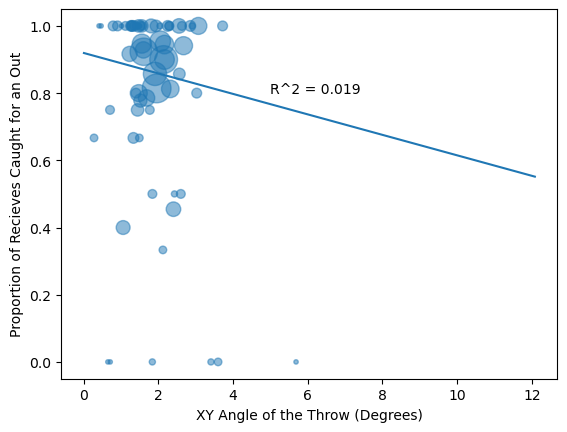

In [247]:
plt.close()

f, a  = plt.subplots()

slope, intercept, r_value, p_value, std_err = stats.linregress(all_data["xy_throw_angle_throw"], all_data["target"])

a.scatter(xy_summary_stats["xy_throw_angle_throw"]["mean"], xy_summary_stats["target"]["mean"], s=xy_summary_stats["xy_throw_angle_throw"]["count"]*10, marker="o", alpha=0.5)

#a.scatter(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], marker="o", alpha=0.2)


a.plot(np.unique(all_data["xy_throw_angle_throw"]), np.unique(all_data["xy_throw_angle_throw"]) * slope + intercept)

#a.plot(np.unique(all_data["target"]), np.poly1d(np.polyfit(all_data["target"], all_data["xy_throw_angle_throw"], 1))(np.unique(all_data["target"])))

#a.plot(np.unique(these_not_outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(these_not_outs["dist_from_bag_receive"], these_not_outs["shorten_throw_by"], 1))(np.unique(these_not_outs["dist_from_bag_receive"])))

a.text(5, 0.8, "R^2 = {}".format(round(r_value**2,ndigits=3)))


plt.ylabel("Proportion of Recieves Caught for an Out")

plt.xlabel("XY Angle of the Throw (Degrees)")

plt.show()

In [222]:
np.poly1d(np.polyfit(all_data["target"], all_data["xy_throw_angle_throw"], 1))(np.unique(all_data["target"]))

array([2.45039841, 1.82798164])

## Compute angle features, and make a plot of it!

In [156]:
train[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values[0,: ]

array([-35.5353 , 121.1655 ,   5.69469])

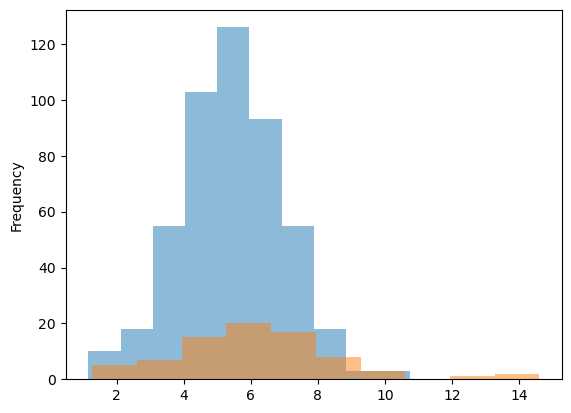

In [249]:
plt.close()

f, a  = plt.subplots()

outs["dist_from_bag_receive"].plot(kind="hist", alpha=0.5, ax=a)
not_outs["dist_from_bag_receive"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

### Stretching? Efficiency? Does that matter?

In [ ]:
plt.close()

f, a  = plt.subplots()

these_outs = train.loc[
    (train["target"] == 1) &
    (train["xy_throw_angle_throw"] < 5),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)


these_not_outs = train.loc[
    (train["target"] == 0) &
    (train["xy_throw_angle_throw"] < 5),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)

a.scatter(these_outs["dist_from_bag_receive"], these_outs["shorten_throw_by"], marker="o", alpha=0.2)

a.scatter(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], marker="o", alpha=0.2)




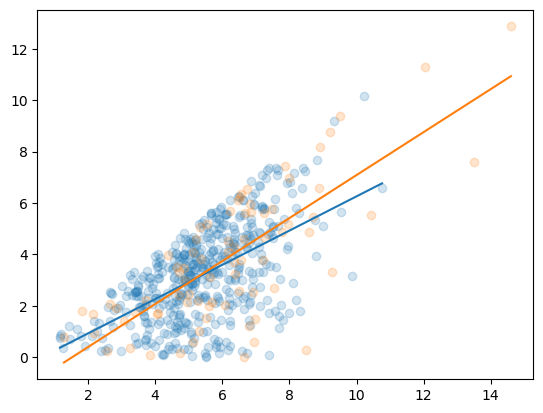

In [258]:
plt.close()

f, a  = plt.subplots()

these_outs = train.loc[
    (train["target"] == 1) &
    (train["xy_throw_angle_throw"] < 5),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)


these_not_outs = train.loc[
    (train["target"] == 0) &
    (train["xy_throw_angle_throw"] < 5),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)

a.scatter(these_outs["dist_from_bag_receive"], these_outs["shorten_throw_by"], marker="o", alpha=0.2)

a.scatter(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], marker="o", alpha=0.2)


a.plot(np.unique(these_outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(these_outs["dist_from_bag_receive"], these_outs["shorten_throw_by"], 1))(np.unique(these_outs["dist_from_bag_receive"])))

a.plot(np.unique(these_not_outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(these_not_outs["dist_from_bag_receive"], these_not_outs["shorten_throw_by"], 1))(np.unique(these_not_outs["dist_from_bag_receive"])))


plt.show()

**Null Finding!** There isn't a difference in "stretch efficiency"

In [159]:
train

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,shorten_throw_by
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,0.0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.53530,121.16550,5.694690,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1,5.116850,4.399956
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,0.0,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.59556,137.95980,5.613210,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1,5.995480,4.652653
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,0.0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.21340,6.006360,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1,7.230630,5.767047
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,185.0,6993.0,4.0,2.377584,4.687237,0.0,63.133569,39.970366,30.3021,121.4715,35.5083,35.2449,29.72007,117.49770,5.624520,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,21.603012,NaN,NaN,48.4122,48.3159,59.3652,62.8815,6.934410,1,8.181159,2.240445
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,223.0,4044.0,1.0,6.460406,-2.494484,0.0,63.042179,34.974859,25.4832,32.9205,38.4414,39.3849,30.47940,33.86130,5.690250,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,20.634997,NaN,NaN,48.4140,49.7118,60.6081,67.4022,1.922883,1,5.200444,0.012828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1903_29_TeamNF_TeamA2,NaN,trusted_first_base_not_out_throws,235.0,8230.0,5.0,3.133706,6.068064,0.0,69.847228,25.213226,-13.3875,83.3025,45.7026,45.9204,-13.94433,79.62300,3.564360,NaN,trusted_first_base_not_out_receives,4728.0,3.0,NaN,NaN,0.0,NaN,1.852603,NaN,NaN,62.3514,62.3082,61.9590,67.0704,5.236680,0,6.482097,2.571330
88,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,24.0,9991.0,2.0,3.905028,2.495060,0.0,71.768956,NaN,NaN,NaN,NaN,NaN,5.06799,19.12845,4.529010,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,71.1648,72.6894,2.551845,0,12.043217,11.288579
89,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,38.0,7468.0,4.0,1.037926,5.407066,0.0,66.640980,35.784509,38.8428,137.2914,37.5894,39.1056,36.45660,135.84750,3.861210,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,13.036025,NaN,NaN,53.3625,55.6197,63.7560,63.3762,3.834150,0,3.844950,0.095528
90,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_throws,237.0,4131.0,1.0,5.854195,17.025390,0.0,29.724053,44.351118,25.2450,53.1012,30.5565,34.1010,26.88408,55.15740,2.358609,NaN,trusted_first_base_not_out_receives,6672.0,3.0,NaN,NaN,0.0,NaN,19.564819,NaN,NaN,48.5805,51.1494,61.2372,66.3597,4.883250,0,6.084126,2.030604


In [160]:
outs = train.loc[
    (train["target"] == 1) &
    (train["xy_throw_angle_throw"] < 3),
    ["player_id_receive", "target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)


not_outs = train.loc[
    (train["target"] == 0) &
    (train["xy_throw_angle_throw"] < 3),
    ["player_id_receive", "target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)



In [161]:
grouped_outs = outs.groupby(["player_id_receive", "target"]).agg(["mean", "count"])

grouped_not_outs = not_outs.groupby(["player_id_receive", "target"]).agg(["mean", "count"])

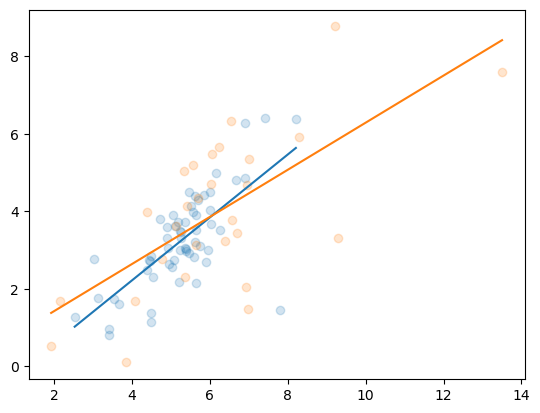

In [95]:
plt.close()

f, a  = plt.subplots()

a.scatter(grouped_outs["dist_from_bag_receive"]["mean"], grouped_outs["shorten_throw_by"]["mean"], marker="o", alpha=0.2)

a.scatter(grouped_not_outs["dist_from_bag_receive"]["mean"], grouped_not_outs["shorten_throw_by"]["mean"], marker="o", alpha=0.2)


a.plot(np.unique(grouped_outs["dist_from_bag_receive"]["mean"]), np.poly1d(np.polyfit(grouped_outs["dist_from_bag_receive"]["mean"], grouped_outs["shorten_throw_by"]["mean"], 1))(np.unique(grouped_outs["dist_from_bag_receive"]["mean"])))
a.plot(np.unique(grouped_not_outs["dist_from_bag_receive"]["mean"]), np.poly1d(np.polyfit(grouped_not_outs["dist_from_bag_receive"]["mean"], grouped_not_outs["shorten_throw_by"]["mean"], 1))(np.unique(grouped_not_outs["dist_from_bag_receive"]["mean"])))


plt.show()

In [93]:
grouped_outs

dist_from_bag_receive       shorten_throw_by      
                                          mean count             mean count
player_id_receive target                                                   
1009.0            1                   4.944488    23         2.639672    23
1119.0            1                   7.415449     2         6.403733     2
1167.0            1                   5.252493     5         3.304382     5
1286.0            1                   5.630735    17         3.915891    17
1334.0            1                   6.681251     3         4.806217     3
1784.0            1                   5.751322    19         3.110036    19
1851.0            1                   6.017988     5         3.677691     5
1918.0            1                   5.615663    41         3.199877    41
1928.0            1                   4.490159     5         1.152218     5
1980.0            1                   3.675873     1         1.609815     1
2196.0            1                   4.922491     4         3.054191     4
2227.0            1                   4.462722     4         2.703829     4
2240.0            1                   6.167848    10         4.990503    10
2382.0            1                   5.072273     4         2.737434     4
2467.0            1                   6.900913     4         4.856155     4
2480.0            1                   5.646099    33         3.504417    33
2488.0            1                   5.470865    12         2.911305    12
2526.0            1                   6.000376    33         4.022124    33
2737.0            1                   2.527010     2         1.257648     2
2774.0            1                   5.608602     2         4.389978     2
2911.0            1                   6.889524     1         6.276821     1
3041.0            1                   5.225888    13         3.000395    13
3134.0            1                   5.098088     1         3.627010     1
3191.0            1                   5.461322     3         4.501015     3
3317.0            1                   5.651642     6         2.149963     6
3710.0            1                   5.184640     6         3.710414     6
4086.0            1                   5.900745     8         2.679131     8
4088.0            1                   3.406486     1         0.794765     1
4202.0            1                   3.124017     1         1.755278     1
4422.0            1                   4.495951     4         2.848188     4
4507.0            1                   4.550230     9         2.304157     9
4579.0            1                   8.207576     2         6.384501     2
4728.0            1                   5.518089     7         4.137116     7
4745.0            1                   5.839408     2         4.423079     2
4794.0            1                   5.590771     4         2.811797     4
5196.0            1                   3.405046     2         0.969712     2
5458.0            1                   5.051967     4         3.910113     4
5524.0            1                   4.885933     9         3.605668     9
5616.0            1                   6.267055     3         3.512293     3
5722.0            1                   5.236496     5         3.494053     5
6158.0            1                   4.498326     2         1.364682     2
6266.0            1                   5.209600    16         2.182841    16
6442.0            1                   5.381227    17         2.974310    17
6523.0            1                   4.390773    12         2.480967    12
6693.0            1                   4.426591     3         2.748604     3
6789.0            1                   5.687962    12         4.282707    12
6803.0            1                   5.951134    10         2.993014    10
8020.0            1                   5.253236     7         3.462407     7
8151.0            1                   5.032566     4         2.549968     4
8183.0            1                   4.723737     5         3.798730    

In [96]:
diff_outs = grouped_outs.merge(grouped_not_outs, how="inner", on="player_id_receive", suffixes=["_outs", "_not_outs"])

In [97]:
diff_outs

dist_from_bag_receive_outs       shorten_throw_by_outs  \
                                        mean count                  mean   
player_id_receive                                                          
1009.0                              4.944488    23              2.639672   
1119.0                              7.415449     2              6.403733   
1334.0                              6.681251     3              4.806217   
1918.0                              5.615663    41              3.199877   
2196.0                              4.922491     4              3.054191   
2227.0                              4.462722     4              2.703829   
2240.0                              6.167848    10              4.990503   
2382.0                              5.072273     4              2.737434   
2480.0                              5.646099    33              3.504417   
2488.0                              5.470865    12              2.911305   
2526.0                              6.000376    33              4.022124   
2774.0                              5.608602     2              4.389978   
3041.0                              5.225888    13              3.000395   
4088.0                              3.406486     1              0.794765   
4728.0                              5.518089     7              4.137116   
4745.0                              5.839408     2              4.423079   
5196.0                              3.405046     2              0.969712   
6442.0                              5.381227    17              2.974310   
6523.0                              4.390773    12              2.480967   
6789.0                              5.687962    12              4.282707   
8151.0                              5.032566     4              2.549968   
8785.0                              5.352956     7              3.040937   
8977.0                              5.360421    10              3.726305   

                        dist_from_bag_receive_not_outs        \
                  count                           mean count   
player_id_receive                                              
1009.0               23                       5.325230     1   
1119.0                2                       5.556656     1   
1334.0                3                       6.554829     1   
1918.0               41                       6.698655     2   
2196.0                4                       5.125148     6   
2227.0                4                       4.766252     5   
2240.0               10                       6.980679     1   
2382.0                4                       6.921813     2   
2480.0               33                       6.017391     4   
2488.0               12                       6.951642     3   
2526.0               33                       6.046036     3   
2774.0                2                       6.390222     1   
3041.0               13                       5.354259     2   
4088.0                1                       1.922348     2   
4728.0                7                       5.631779     1   
4745.0                2                       9.208614     1   
5196.0                2                       6.225153     1   
6442.0               17                      13.502941     1   
6523.0               12                       6.546595     1   
6789.0               12                       9.281085     1   
8151.0                4                       2.137035     1   
8785.0                7                       5.413253     2   
8977.0               10                       5.693065     2   

                  shorten_throw_by_not_outs        
                                       mean count  
player_id_receive                                  
1009.0                             5.047448     1  
1119.0                             5.193793     1  
1334.0                             3.768187     1  
1918.0                             3.435562     2  
2196.0      

In [98]:
diff_outs["success_percentage"] = diff_outs.apply(lambda row:
               (row["dist_from_bag_receive_outs"]["count"] / (row["dist_from_bag_receive_not_outs"]["count"] + row["dist_from_bag_receive_outs"]["count"]))
               , axis = 1)

In [99]:
diff_outs["diff_stretch_efficiency"] = diff_outs.apply(lambda row:
               (row["shorten_throw_by_outs"]["mean"] / row["dist_from_bag_receive_outs"]["mean"]) - (row["shorten_throw_by_not_outs"]["mean"] / row["dist_from_bag_receive_not_outs"]["mean"]) 
               , axis = 1)

In [100]:
diff_outs

dist_from_bag_receive_outs       shorten_throw_by_outs  \
                                        mean count                  mean   
player_id_receive                                                          
1009.0                              4.944488    23              2.639672   
1119.0                              7.415449     2              6.403733   
1334.0                              6.681251     3              4.806217   
1918.0                              5.615663    41              3.199877   
2196.0                              4.922491     4              3.054191   
2227.0                              4.462722     4              2.703829   
2240.0                              6.167848    10              4.990503   
2382.0                              5.072273     4              2.737434   
2480.0                              5.646099    33              3.504417   
2488.0                              5.470865    12              2.911305   
2526.0                              6.000376    33              4.022124   
2774.0                              5.608602     2              4.389978   
3041.0                              5.225888    13              3.000395   
4088.0                              3.406486     1              0.794765   
4728.0                              5.518089     7              4.137116   
4745.0                              5.839408     2              4.423079   
5196.0                              3.405046     2              0.969712   
6442.0                              5.381227    17              2.974310   
6523.0                              4.390773    12              2.480967   
6789.0                              5.687962    12              4.282707   
8151.0                              5.032566     4              2.549968   
8785.0                              5.352956     7              3.040937   
8977.0                              5.360421    10              3.726305   

                        dist_from_bag_receive_not_outs        \
                  count                           mean count   
player_id_receive                                              
1009.0               23                       5.325230     1   
1119.0                2                       5.556656     1   
1334.0                3                       6.554829     1   
1918.0               41                       6.698655     2   
2196.0                4                       5.125148     6   
2227.0                4                       4.766252     5   
2240.0               10                       6.980679     1   
2382.0                4                       6.921813     2   
2480.0               33                       6.017391     4   
2488.0               12                       6.951642     3   
2526.0               33                       6.046036     3   
2774.0                2                       6.390222     1   
3041.0               13                       5.354259     2   
4088.0                1                       1.922348     2   
4728.0                7                       5.631779     1   
4745.0                2                       9.208614     1   
5196.0                2                       6.225153     1   
6442.0               17                      13.502941     1   
6523.0               12                       6.546595     1   
6789.0               12                       9.281085     1   
8151.0                4                       2.137035     1   
8785.0                7                       5.413253     2   
8977.0               10                       5.693065     2   

                  shorten_throw_by_not_outs       success_percentage  \
                                       mean count                      
player_id_receive                                                      
1009.0                             5.047448     1           0.958333   
1119.0                             5.193793     1           0.666667   
1334.0          

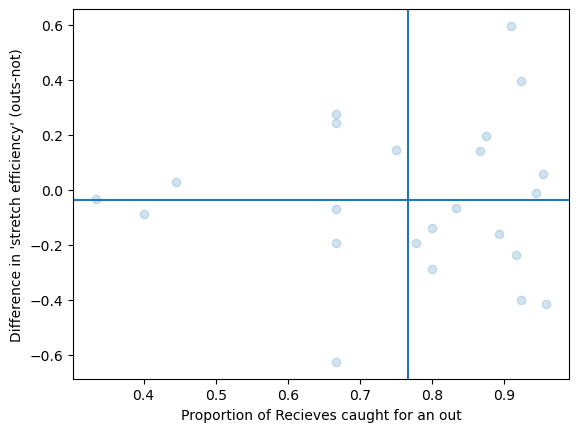

In [91]:
plt.close()

f, a  = plt.subplots()

a.scatter(diff_outs["success_percentage"], diff_outs["diff_stretch_efficiency"], marker="o", alpha=0.2)


plt.axvline(diff_outs["success_percentage"].mean())

plt.axhline(diff_outs["diff_stretch_efficiency"].mean())



# a.scatter(grouped_not_outs["dist_from_bag_receive"], grouped_not_outs["shorten_throw_by"], marker="o", alpha=0.2)


#a.plot(np.unique(outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(outs["dist_from_bag_receive"], outs["shorten_throw_by"], 1))(np.unique(outs["dist_from_bag_receive"])))

#a.plot(np.unique(not_outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], 1))(np.unique(not_outs["dist_from_bag_receive"])))


plt.xlabel("Proportion of Recieves caught for an out")

plt.ylabel("Difference in 'stretch efficiency' (outs-not)")


plt.show()

## Try to replicate Distance-Time Intercept Model in this context

In [411]:
outs

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,dist_from_bag_throw,shorten_throw_by,batter_time_to_first_throw,throw_time_to_first_throw
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,0.0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.53530,121.16550,5.694690,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1,5.116850,114.792510,4.399956,1.924225,1.076765
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,0.0,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.59556,137.95980,5.613210,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1,5.995480,115.500840,4.652653,2.002858,1.052458
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,0.0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.21340,6.006360,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1,7.230630,85.946530,5.767047,1.063900,0.937100
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,185.0,6993.0,4.0,2.377584,4.687237,0.0,63.133569,39.970366,30.3021,121.4715,35.5083,35.2449,29.72007,117.49770,5.624520,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,21.603012,NaN,NaN,48.4122,48.3159,59.3652,62.8815,6.934410,1,8.181159,63.897295,2.240445,1.480384,0.690050
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,223.0,4044.0,1.0,6.460406,-2.494484,0.0,63.042179,34.974859,25.4832,32.9205,38.4414,39.3849,30.47940,33.86130,5.690250,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,20.634997,NaN,NaN,48.4140,49.7118,60.6081,67.4022,1.922883,1,5.200444,44.930238,0.012828,1.295365,0.485922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,188.0,3727.0,6.0,0.552094,3.544626,0.0,64.710995,36.947705,14.7525,130.4877,38.6280,36.4449,14.96361,125.74440,4.365840,NaN,trusted_first_base_out_receives,8183.0,3.0,NaN,NaN,0.0,NaN,13.423730,NaN,NaN,54.1467,54.1485,61.4487,65.7189,2.347149,1,3.825264,79.027960,3.113150,1.368434,0.832648
481,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,198.0,2608.0,1.0,3.109739,15.644901,0.0,31.369518,26.362099,37.2222,45.7701,44.6925,45.3102,38.31900,47.28210,1.404567,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,8.204738,NaN,NaN,57.3195,58.4076,59.3292,65.7147,4.946880,1,6.881661,30.177380,2.722143,0.976374,0.655892
482,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,203.0,2207.0,4.0,0.339133,9.081065,0.0,52.311022,45.035599,56.2413,129.7479,31.5411,32.0502,53.20170,129.83460,3.536160,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,24.394698,NaN,NaN,46.1169,46.6674,63.2970,65.1057,5.985390,1,6.171847,67.106118,1.814875,1.667985,0.874637
483,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,245.0,1643.0,6.0,1.785634,3.350765,0.0,73.563723,42.896724,-19.9359,151.5210,33.9753,32.6532,-19.63161,149.19000,5.596620,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,17.202228,N

In [418]:
# convert to time, use average sprint speed of 27 ft/s and actual throw velo

close_plays = train.loc[(abs(train["batter_time_to_first_throw"] - train["throw_time_to_first_throw"]) < 0.25),
                       :
   

]

In [420]:
close_plays.shape

(41, 40)

In [419]:
close_plays.target.mean()

0.5121951219512195

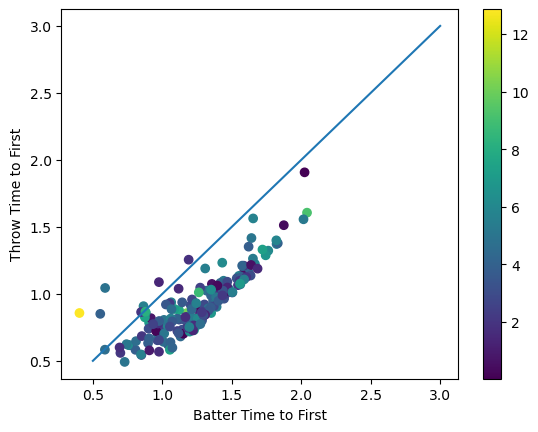

In [436]:
plt.close()

f, a  = plt.subplots()





im= a.scatter(close_outs["batter_time_to_first_throw"],
          close_outs["throw_time_to_first_throw"],
          # c = np.where(close_outs["target"] == 1, 'red', 'blue')
          c = close_outs["shorten_throw_by"]
          
          

        )


a.plot([0.5, 3], [0.5, 3])

plt.xlabel("Batter Time to First")
plt.ylabel("Throw Time to First")

#plt.ylabel("Difference in 'stretch efficiency' (outs-not)")
f.colorbar(im)


plt.show()

## Try to build some Models

In [590]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from scipy.special import expit
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, StratifiedGroupKFold


from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
)

from collections import defaultdict


In [591]:
#train = load_model_data("model_dataset.csv")

In [592]:
train.head()

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,dist_from_bag_throw,shorten_throw_by,batter_time_to_first_throw,throw_time_to_first_throw
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,0.0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.53530,121.1655,5.69469,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1,5.116850,114.792510,4.399956,1.924225,1.076765
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,0.0,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.59556,137.9598,5.61321,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1,5.995480,115.500840,4.652653,2.002858,1.052458
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,0.0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.2134,6.00636,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1,7.230630,85.946530,5.767047,1.063900,0.937100
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,185.0,6993.0,4.0,2.377584,4.687237,0.0,63.133569,39.970366,30.3021,121.4715,35.5083,35.2449,29.72007,117.4977,5.62452,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,21.603012,NaN,NaN,48.4122,48.3159,59.3652,62.8815,6.934410,1,8.181159,63.897295,2.240445,1.480384,0.690050
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,223.0,4044.0,1.0,6.460406,-2.494484,0.0,63.042179,34.974859,25.4832,32.9205,38.4414,39.3849,30.47940,33.8613,5.69025,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,20.634997,NaN,NaN,48.4140,49.7118,60.6081,67.4022,1.922883,1,5.200444,44.930238,0.012828,1.295365,0.485922


In [593]:
train.columns

Index(['game_str', 'play_per_game_throw', 'type_throw', 'play_id',
       'player_id_throw', 'player_position_throw', 'xy_throw_angle_throw',
       'elevation_throw_angle_throw', 'throw_bounced_throw',
       'throw_velo_throw', 'batter_dist_to_first_throw', 'thrower_x_throw',
       'thrower_y_throw', 'batter_x_throw', 'batter_y_throw',
       'ball_position_x_throw', 'ball_position_y_throw',
       'ball_position_z_throw', 'play_per_game_receive', 'type_receive',
       'player_id_receive', 'player_position_receive',
       'xy_throw_angle_receive', 'elevation_throw_angle_receive',
       'throw_bounced_receive', 'throw_velo_receive',
       'batter_dist_to_first_receive', 'thrower_x_receive',
       'thrower_y_receive', 'batter_x_receive', 'batter_y_receive',
       'ball_position_x_receive', 'ball_position_y_receive',
       'ball_position_z_receive', 'target', 'dist_from_bag_receive',
       'dist_from_bag_throw', 'shorten_throw_by', 'batter_time_to_first_throw',
       'throw_ti

In [663]:
all_cols_for_training = ['xy_throw_angle_throw', 'elevation_throw_angle_throw', 'throw_velo_throw', 'throw_bounced_throw', 'batter_dist_to_first_throw', 
                      'batter_x_throw', 'batter_y_throw', 'ball_position_x_receive', 'ball_position_y_receive', 'ball_position_z_receive',
                      'shorten_throw_by', 'dist_from_bag_throw',
             ]

all_cols_for_training = ['xy_throw_angle_throw', 'elevation_throw_angle_throw', 'throw_velo_throw', 
                         'throw_bounced_throw', 'batter_dist_to_first_throw',]

In [664]:
X = train[all_cols_for_training].dropna()
y = train[all_cols_for_training + ["target"]].dropna()["target"]
player_ids = train[all_cols_for_training  + ["player_id_receive"]].dropna()["player_id_receive"]

game_strs = train[all_cols_for_training  + ["game_str"]].dropna()["game_str"]
play_ids = train[all_cols_for_training  + ["play_id"]].dropna()["play_id"]


In [665]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.5, random_state=10) #test_size=0.5, random_state=10)

#### Feature Selection

-  Wasserman, L. (2013). All of Statistics: A Concise Course in Statistical Inference. Springer Science & Business Media. 
    - for the inspo on the F tests
- Maybe pick different models, stats tests

In [666]:

col_subset = ['xy_throw_angle_throw', 'elevation_throw_angle_throw', 'throw_velo_throw', 
              'throw_bounced_throw', 'batter_dist_to_first_throw',
              ]
model_1 = LogisticRegression(C=1e3,  max_iter=1000)
model_1.fit(X_train[col_subset], y_train)
residuals_1 = model_1.predict(X_test[col_subset]) - y_test


model_2 = LogisticRegression(C=1e3,  max_iter=1000)
model_2.fit(X_train, y_train)
residuals_2 = model_2.predict(X_test) - y_test



KeyError: "['elevation_throw_angle_throw'] not in index"

In [667]:
# compute sum of squared residuals
rss_1 = sum([r**2 for r in residuals_1])
rss_2 = sum([r**2 for r in residuals_2])

# number of params in each
k_1, k_2 = len(col_subset), len(X_train.columns)

# number of samples
n = len(residuals_1)

In [668]:
# compute the F statistic
F = ((rss_1 - rss_2) / (k_2 - k_1)) / (rss_2 / (n - k_2))

1 - stats.f.cdf(F, k_2-k_1, n-k_2)

nan

#### Model Selection

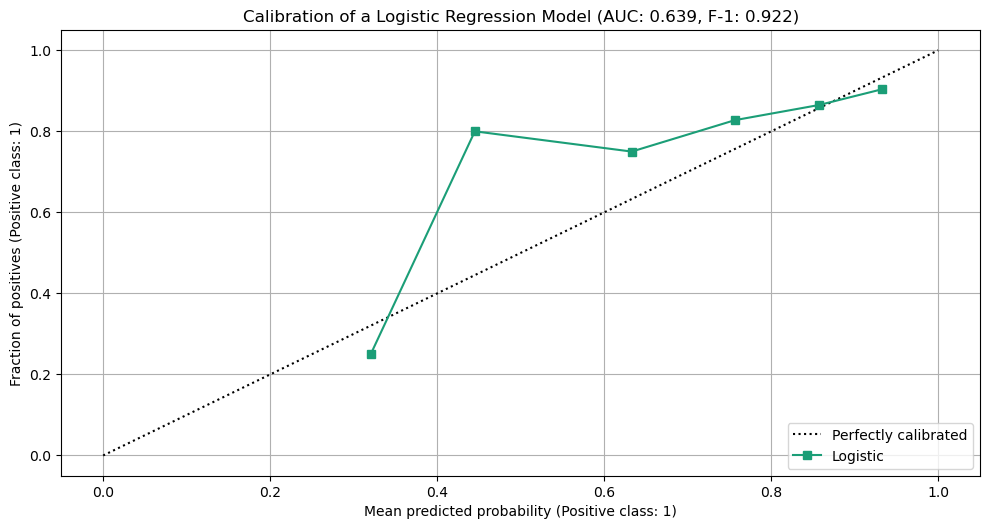

In [669]:
lr = LogisticRegression(C=1e3,  max_iter=1000)

dtc = DecisionTreeClassifier(max_depth=2)

gbc = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='log_loss'
)

rfc = RandomForestClassifier()

gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=3, method="isotonic")

clf_list = [
    (lr, "Logistic"),
    #(gnb, "Gaussian Naive Bayes"),
    #(rfc, "Random Forest"),
    #(gbc, "Gradient Boosted"),
    #(dtc, "Decision Tree"),
    #(gnb_isotonic, "Gaussian Naive Bayes + iso"),
    
]


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),

    )
    calibration_displays[name] = display

ax_calibration_curve.grid()

"""
# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")


"""

y_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)


plt.title("Calibration of a Logistic Regression Model (AUC: {}, F-1: {})".format(round(roc_auc_score(y_test, y_prob[:, 1]), ndigits=3),
                                                                                 round(f1_score(y_test, y_pred), ndigits=3)))

plt.tight_layout()
plt.show()




In [670]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Mean squared error,Precision,Recall,F1
Classifier,,,,,,,
Logistic,0.115554,0.38931,0.63943,0.115554,0.870849,0.979253,0.921875


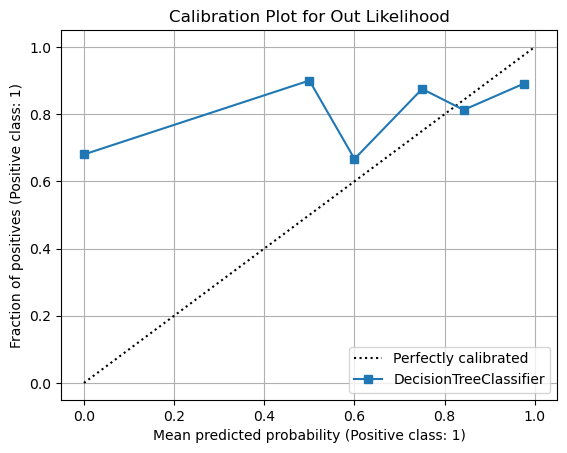

In [662]:
dtr = DecisionTreeClassifier(max_depth=6)


dtr.fit(X_train, y_train)

plt.close()

CalibrationDisplay.from_estimator(
    dtr,
    X_test,
    y_test,
    n_bins = 10,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()

In [652]:
scores = defaultdict(list)

dtr.fit(X_train, y_train)
y_prob = dtr.predict_proba(X_test)
y_pred = dtr.predict(X_test)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc,Mean squared error
0,0.1617,3.147201,0.594265,0.1617


/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


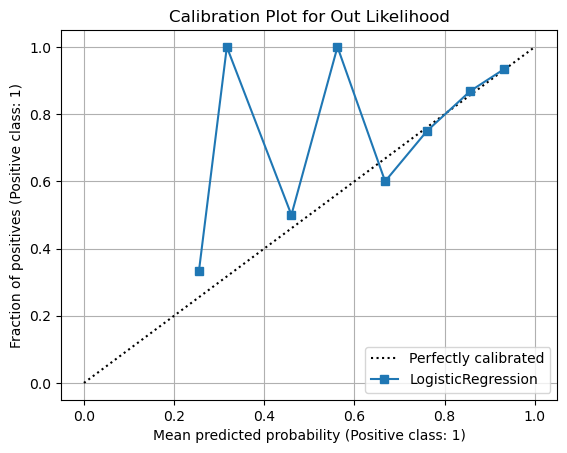

In [653]:
clf = LogisticRegression(C=1000)

clf.fit(X_train, y_train)

plt.close()

CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins = 10,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()


In [632]:
from collections import defaultdict
scores = defaultdict(list)

clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc,Mean squared error
0,0.114383,0.38649,0.648686,0.114383


In [509]:
clf = LogisticRegression(C=1e5)
clf.fit(X, y.values.ravel())

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0)

In [510]:
clf.coef_

array([[-0.23122955, -0.09053357, -0.03180812, -1.45813743,  0.11113266,
        -0.0089218 ,  0.09966457,  0.04058115, -0.03458904, -0.01697599,
        -0.0227352 , -0.11114853]])

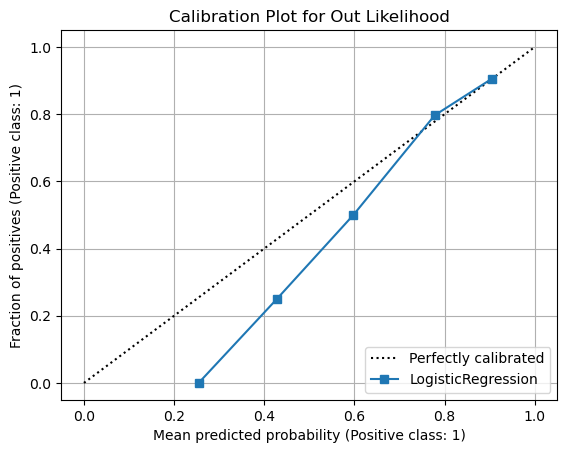

In [511]:
plt.close()

CalibrationDisplay.from_estimator(
    clf,
    X,
    y,
    n_bins = 6,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()

In [512]:
scores = defaultdict(list)

clf.fit(X, y)
y_prob = clf.predict_proba(X)
y_pred = clf.predict(X)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y, y_prob[:, 1]))

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [486]:
pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc,Mean squared error
0,0.109498,0.37035,0.68198,0.109498


### Do the prediction and compute the "scores" for each player, with the n

In [487]:
full_data = X.copy()

#clf = RandomForestClassifier()
clf = LogisticRegression(C=1000, max_iter=1000)

clf.fit(X, y)


full_data["predicted_prob"] = clf.predict_proba(X)[:, 1]
full_data["target"] = y
full_data["receiver_id"] = player_ids
full_data["game_str"] = game_strs
full_data["play_id"] = play_ids


full_data["scoops_scores"] = full_data.apply(
    lambda row: row["target"] * 1 - row["predicted_prob"], 
    axis = 1
)


In [488]:
full_data.sort_values(by="scoops_scores", ascending=True)[:50]


## print this as a csv, use this to remap labels!

full_data.sort_values(by="scoops_scores", ascending=True).to_csv("logisitc_predicted_scoop_scores.csv")

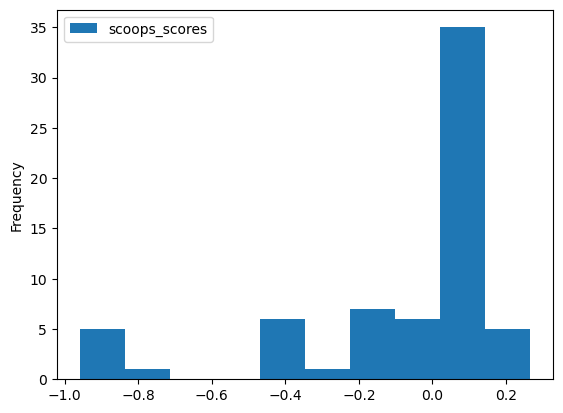

In [489]:
# can slice this up a bunch of different ways
# - by year, by player, by level, etc

cols = ["receiver_id", "scoops_scores"]

full_data[cols].groupby("receiver_id").mean().plot(kind="hist")

plt.show()

In [490]:
cols = ["receiver_id", "scoops_scores"]
# mean_scoops_score = full_data["scoops_scores"].mean()


full_data[cols].groupby("receiver_id").describe().sort_values(by = ("scoops_scores", "count"), ascending=False)

scoops_scores                                                    \
                    count      mean       std       min       25%       50%   
receiver_id                                                                   
2480.0               42.0 -0.068919  0.369172 -0.940717  0.036809  0.063159   
2526.0               40.0  0.088758  0.318943 -0.949548  0.086985  0.143608   
1918.0               39.0  0.059005  0.240260 -0.919288  0.059429  0.119028   
1009.0               28.0  0.000333  0.296204 -0.884836  0.071742  0.093096   
1784.0               22.0  0.083585  0.218974 -0.836282  0.075490  0.116997   
...                   ...       ...       ...       ...       ...       ...   
5921.0                1.0 -0.959463       NaN -0.959463 -0.959463 -0.959463   
9618.0                1.0  0.063093       NaN  0.063093  0.063093  0.063093   
4202.0                1.0  0.086240       NaN  0.086240  0.086240  0.086240   
9753.0                1.0 -0.903387       NaN -0.903387 -0.903387 -0.903387   
2911.0                1.0  0.140890       NaN  0.140890  0.140890  0.140890   

                                 
                  75%       max  
receiver_id                      
2480.0       0.096211  0.321700  
2526.0       0.204133  0.629376  
1918.0       0.138872  0.290538  
1009.0       0.129476  0.311212  
1784.0       0.155479  0.383442  
...               ...       ...  
5921.0      -0.959463 -0.959463  
9618.0       0.063093  0.063093  
4202.0       0.086240  0.086240  
9753.0      -0.903387 -0.903387  
2911.0       0.140890  0.140890  

[66 rows x 8 columns]

In [491]:
full_data.loc[
    full_data["receiver_id"] == 1918

].sort_values(by="scoops_scores", ascending=False)

,xy_throw_angle_throw,elevation_throw_angle_throw,throw_velo_throw,throw_bounced_throw,batter_dist_to_first_throw,dist_from_bag_throw,batter_x_throw,batter_y_throw,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,predicted_prob,target,receiver_id,game_str,play_id,scoops_scores
326,3.679479,2.073540,82.566098,0.0,45.297837,121.754017,30.6780,32.5683,59.3859,67.1955,1.773342,0.709462,1,1918.0,1902_09_TeamMJ_TeamB,184.0,0.290538
345,2.722632,2.551618,83.904471,0.0,49.248993,127.871791,29.1546,28.4793,61.2321,66.6354,2.399382,0.766207,1,1918.0,1903_25_TeamNK_TeamB,188.0,0.233793
125,1.389200,6.023353,79.338164,0.0,39.617213,119.892301,35.5788,35.6733,61.4823,63.0945,4.037970,0.799932,1,1918.0,1902_15_TeamMK_TeamB,40.0,0.200068
436,2.149352,3.357234,81.640686,0.0,41.585148,122.662510,33.8154,34.6596,62.6985,61.0173,2.433555,0.802108,1,1918.0,1903_21_TeamNL_TeamB,139.0,0.197892
431,1.221056,7.889140,67.579654,0.0,49.205657,135.986839,28.0344,29.6769,57.8436,63.4647,0.328107,0.815507,1,1918.0,1903_21_TeamNL_TeamB,39.0,0.184493
303,1.190729,4.456502,81.827503,0.0,43.811303,122.450080,32.3511,32.9727,62.5776,62.4075,3.777120,0.817725,1,1918.0,1903_20_TeamNL_TeamB,245.0,0.182275
305,1.043016,8.297475,68.928426,0.0,48.860963,125.871732,28.0305,30.1824,62.3334,62.1516,3.955080,0.827647,1,1918.0,1902_06_TeamML_TeamB,32.0,0.172353
292,1.788278,6.170310,75.776595,0.0,45.287489,111.537341,31.3938,31.8408,60.6672,58.4826,4.652880,0.838407,1,1918.0,1903_20_TeamNL_TeamB,9.0,0.161593
341,1.762909,1.023021,81.992542,0.0,41.691050,105.923368,34.2210,34.0983,59.7345,64.4778,0.913269,0.852369,1,1918.0,1903_25_TeamNK_TeamB,77.0,0.147631
92,0.237752,5.702037,75.662994,0.0,45.120098,122.969414,31.3446,32.1300,58.8390,61.3671,3.542310,0.860623,1,1918.0,1903_27_TeamNK_TeamB,3.0,0.139377


## Something is wrong with these labels, but explore some plays

In [322]:
bf = Baseball_Field("1903_05_TeamND_TeamA2", which_outs=["full_seq"])

g_info = bf.game_obj.game_info_df.copy()
g_events = bf.game_obj.game_events_df.copy()


Distance between ball and player is large on average, should maybe clean up 14.67974023000007


In [323]:
bf.clear_plot()


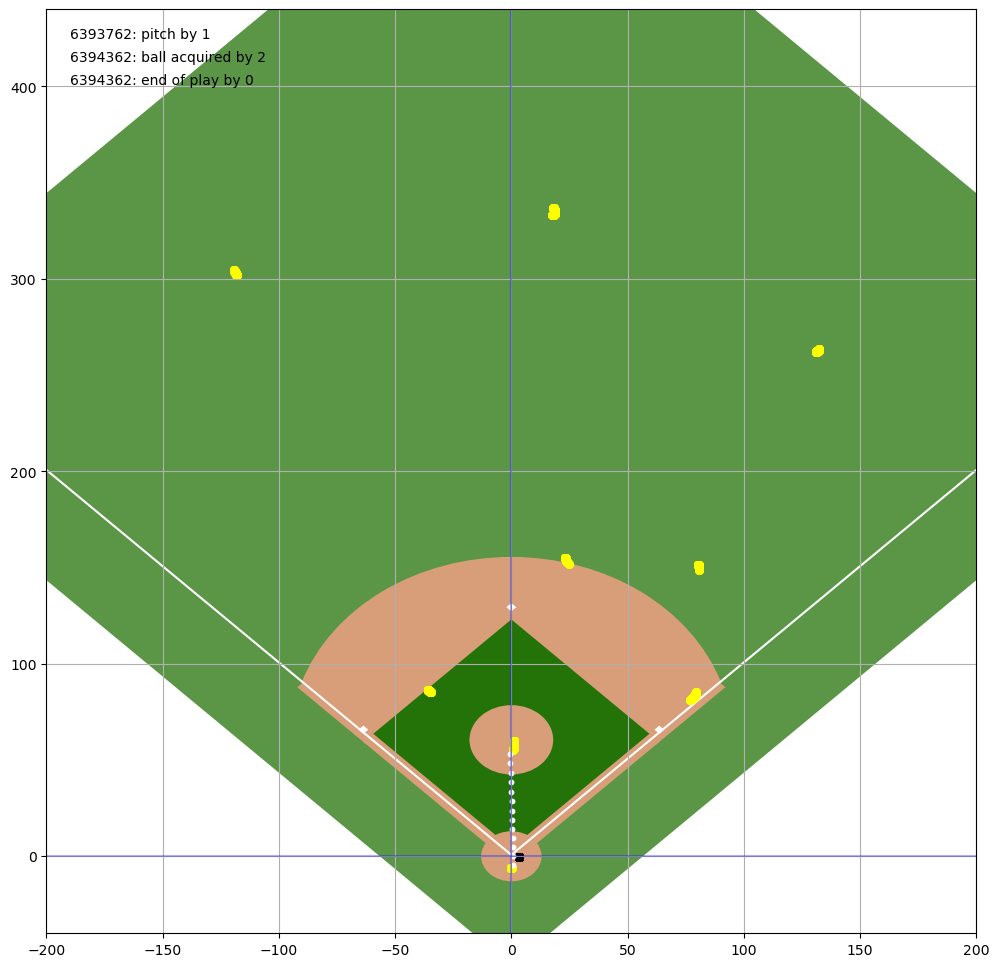

In [333]:
bf.clear_plot()

play_id = 201 # bf.game_obj.get_pid_from_ppg(244)
bf.plot_all_components(play_id=play_id)
bf.fig

# bf.create_gif(play_id=play_id, tag="--95% chance out, converted")

In [ ]:
bf.game_obj.get_ppg_from_pid(play_id)

In [ ]:
g_info.loc[
    g_info["inning"] == 4,
    :

]


## Make a 3D plot of where the balls ended up!

### Where the balls were received

In [172]:
outs

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target,dist_from_bag_receive,shorten_throw_by
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,0.0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.53530,121.16550,5.694690,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1,5.116850,4.399956
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,0.0,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.59556,137.95980,5.613210,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1,5.995480,4.652653
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,0.0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.21340,6.006360,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1,7.230630,5.767047
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,185.0,6993.0,4.0,2.377584,4.687237,0.0,63.133569,39.970366,30.3021,121.4715,35.5083,35.2449,29.72007,117.49770,5.624520,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,21.603012,NaN,NaN,48.4122,48.3159,59.3652,62.8815,6.934410,1,8.181159,2.240445
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,223.0,4044.0,1.0,6.460406,-2.494484,0.0,63.042179,34.974859,25.4832,32.9205,38.4414,39.3849,30.47940,33.86130,5.690250,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,0.0,NaN,20.634997,NaN,NaN,48.4140,49.7118,60.6081,67.4022,1.922883,1,5.200444,0.012828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,188.0,3727.0,6.0,0.552094,3.544626,0.0,64.710995,36.947705,14.7525,130.4877,38.6280,36.4449,14.96361,125.74440,4.365840,NaN,trusted_first_base_out_receives,8183.0,3.0,NaN,NaN,0.0,NaN,13.423730,NaN,NaN,54.1467,54.1485,61.4487,65.7189,2.347149,1,3.825264,3.113150
481,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,198.0,2608.0,1.0,3.109739,15.644901,0.0,31.369518,26.362099,37.2222,45.7701,44.6925,45.3102,38.31900,47.28210,1.404567,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,8.204738,NaN,NaN,57.3195,58.4076,59.3292,65.7147,4.946880,1,6.881661,2.722143
482,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,203.0,2207.0,4.0,0.339133,9.081065,0.0,52.311022,45.035599,56.2413,129.7479,31.5411,32.0502,53.20170,129.83460,3.536160,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,24.394698,NaN,NaN,46.1169,46.6674,63.2970,65.1057,5.985390,1,6.171847,1.814875
483,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,245.0,1643.0,6.0,1.785634,3.350765,0.0,73.563723,42.896724,-19.9359,151.5210,33.9753,32.6532,-19.63161,149.19000,5.596620,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,0.0,NaN,17.202228,NaN,NaN,51.4695,51.4821,60.3270,68.0484,2.670495,1,6.127182,5.588871


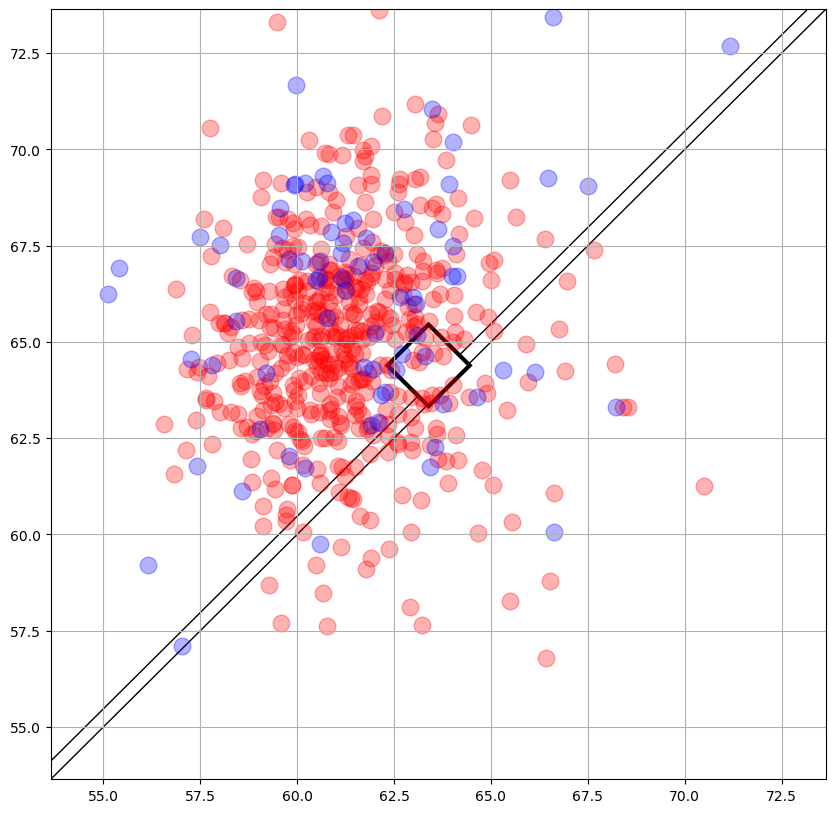

In [173]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

ax.scatter(
    outs["ball_position_x_receive"], 
    outs["ball_position_y_receive"], 
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="red"
)


ax.scatter(
    not_outs["ball_position_x_receive"], 
    not_outs["ball_position_y_receive"],  
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="blue"
)


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

plt.grid()

plt.show()

### Try again with a hexbin and a mean

In [174]:
hex_plotting = pd.concat([outs, not_outs])

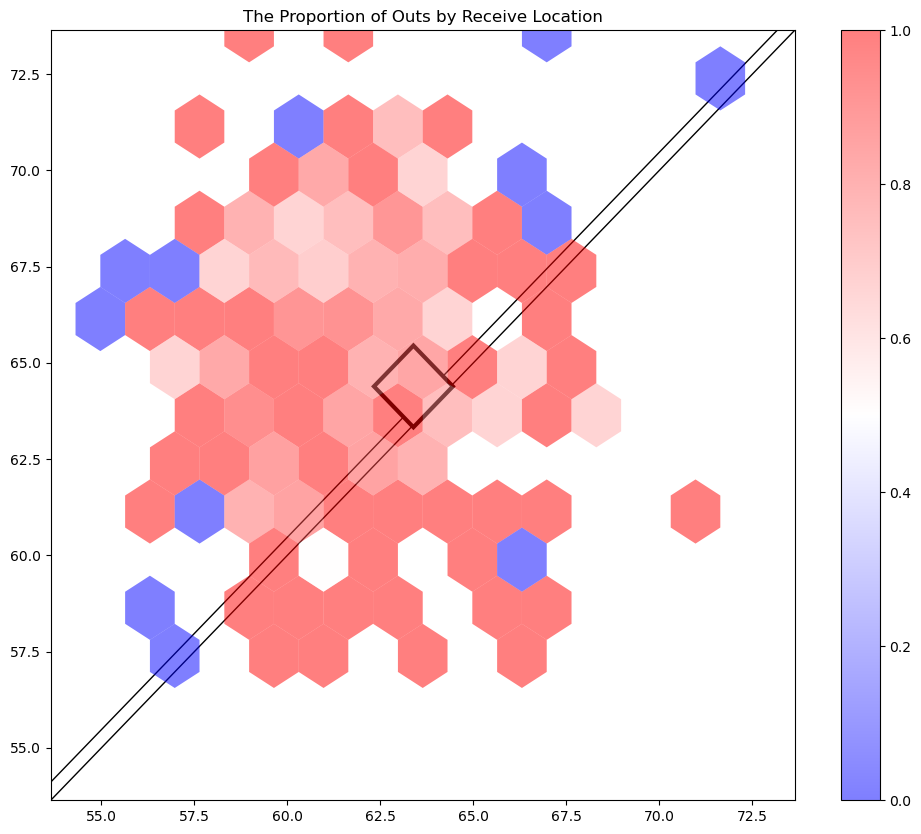

In [259]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

im = ax.hexbin(hex_plotting["ball_position_x_receive"], 
          hex_plotting["ball_position_y_receive"], 
          C = hex_plotting["target"],
          cmap="bwr", 
          extent = ((first_base_point[0] - 10, first_base_point[0] + 10, first_base_point[1] - 10, first_base_point[1] + 10)),
          edgecolors=None,
          gridsize=15, 
          alpha=0.5) 


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

fig.colorbar(im)

# plt.grid()
plt.title("The Proportion of Outs by Receive Location")

plt.show()

### IDK WHY THIS 3D STUFF ISN'T WORKING

In [ ]:
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, Rectangle

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    trusted_first_base_receives["ball_position_x"], 
    trusted_first_base_receives["ball_position_y"], 
    trusted_first_base_receives["ball_position_z"], 
    alpha=1,
    marker='o',
    color = "red"
)

first_base_point = [63.63961031, 63.63961031]

first_base_line = Rectangle(
    (40, 40), 
    30, 
    1/3,
    edgecolor = 'black',
    facecolor= "white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_base_line)

art3d.pathpatch_2d_to_3d(
    first_base_line, 
    z=0, 
    zdir="z"
)


first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

art3d.pathpatch_2d_to_3d(
    first_base, 
    z=0, 
    zdir="z"
)

ax.set_xlim(first_base_point[0] - 5, first_base_point[0] + 5)
ax.set_ylim(first_base_point[1] - 5, first_base_point[1] + 5)
ax.set_zlim(-0.1, 8)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect("equalxy")

ax.elev = 10 # 3 is roughly Center field camera angle
ax.azim = 10  # xy view 10 is over right shoulder

plt.show()

### Where the balls landed when thrown?
- This would be the same as before, but for all the plays where the ball bounced, use that coord instead and the ball acquired one!
- Maybe "whether the ball bounced"

In [ ]:
bf = Baseball_Field("1902_13_TeamMK_TeamB", which_outs=["at_first"])

g_info = bf.game_obj.game_info_df.copy()
g_events = bf.game_obj.game_events_df.copy()


In [ ]:
not_outs = g_info.loc[
    g_info["is_out_at_first"] == -1,
]

In [ ]:
g_events.head()

In [ ]:
g_events.loc[
    (g_events["play_per_game"].isin(not_outs["play_per_game"].values)) &
    (g_events["event"] == "throw (ball-in-play)") &
    (g_events["next_event"] == "ball bounce"),
    :
]